In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import statsmodels.api as sm

### Scripts

In [35]:
def split_day(dataframe):
    dataframe['Date'] = dataframe.dt.day
    dataframe['Date'] = dataframe.dt.month

In [36]:
def adequacao_serie_plot(dataframe):
    
    dataframe['Data-Hora'] = dataframe.index+ ' ' +dataframe['Intervalo']
    dataframe.set_index('Data-Hora', inplace=True)
    
    dataframe = dataframe.dropna(subset=['Vazao'])

    return dataframe

In [37]:
def substituicao_intervalos_aleatorios(main_dataframe):
    dataframe = main_dataframe.copy()

    min_vazao = dataframe['Vazao'][dataframe['Vazao'] > 0].min()
    max_vazao = dataframe['Vazao'].max()

    # Limitar o valor máximo de high para o intervalo suportado pelo int32
    high = min(max_vazao, np.iinfo(np.int64).max)

    dataframe.loc[dataframe['Vazao'] == -1, 'Vazao'] = np.random.randint(min_vazao, high, dataframe['Vazao'].eq(-1).sum())

    if 'Intervalo' in dataframe.columns:
        dataframe['Data-Hora'] = dataframe.index+ ' ' +dataframe['Intervalo']
        dataframe.set_index('Data-Hora', inplace=True)
        dataframe = dataframe.drop('Intervalo',axis=1)

    return dataframe

In [38]:
def substituicao_intervalos_mean_std(main_dataframe):

    dataframe = main_dataframe.copy()
    dataframe.index = dataframe.index.str.strip()

    datas_unicas = dataframe.index.unique()  # Obtém todas as datas únicas no DataFrame.

    for data in datas_unicas:

        media_vazao = dataframe['Vazao'].mean()
        desvio_padrao_vazao_maior = dataframe['Vazao'].std() + media_vazao
        desvio_padrao_vazao_menor = media_vazao - dataframe['Vazao'].std()

        
        # Limitar o valor máximo de high para o intervalo suportado pelo int32
        #high = min(desvio_padrao_vazao, np.iinfo(np.int64).max)

        dataframe.loc[dataframe['Vazao'] == -1, 'Vazao'] = np.random.randint(desvio_padrao_vazao_menor, desvio_padrao_vazao_maior, dataframe['Vazao'].eq(-1).sum())


    if 'Intervalo' in dataframe.columns:
        dataframe['Data-Hora'] = dataframe.index+ ' ' +dataframe['Intervalo']
        dataframe.set_index('Data-Hora', inplace=True)
        dataframe = dataframe.drop('Intervalo',axis=1)
    
    return dataframe

In [39]:
def categorize_turno(df):
    def categorize_row(row):
        hour = row['Data'].hour
        if 0 <= hour < 6:
            return 'madrugada'
        elif 6 <= hour < 12:
            return 'manhã'
        elif 12 <= hour < 18:
            return 'tarde'
        else:
            return 'noite'

    df['Turno'] = df.apply(categorize_row, axis=1)
    return df

In [99]:
def preencher_valores(df):
    # Criar uma cópia do DataFrame original para evitar modificações
    df_copy = df.copy()

    # Converter a coluna 'Data' para o formato datetime
    df_copy['Data'] = pd.to_datetime(df_copy['Data'])

    # Criar uma coluna 'Sintético' preenchida com zeros (0) por padrão
    df_copy['Sintético'] = 0

    # Agrupar pelo dia e calcular a média dos valores
    grupos = df_copy.groupby(df_copy['Data'].dt.date)
    for data, grupo in grupos:
        dia = grupo['Data'].dt.date.iloc[0]
        
        # Verificar se o grupo tem menos de 6 valores
        if len(grupo) < 6:
            # Calcular a média dos valores do grupo
            media_valores = grupo['Vazao'].mean()

            # Preencher as linhas faltantes com horários aleatórios e valores médios
            horas = [random.randint(0, 23) for _ in range(6 - len(grupo))]
            minutos = [random.randint(0, 59) for _ in range(6 - len(grupo))]
            segundos = [random.randint(0, 59) for _ in range(6 - len(grupo))]
            datas_novas = [pd.Timestamp(dia.year, dia.month, dia.day, h, m, s) for h, m, s in zip(horas, minutos, segundos)]

            novas_linhas = pd.DataFrame({
                'Data': datas_novas,
                'Vazao': media_valores,
                'Sintético': 1  # Marcar como valor sintético
            })

            df_copy = pd.concat([df_copy, novas_linhas], ignore_index=True)

    # Preencher a coluna de timestamp convertendo as datas geradas aleatoriamente
    df_copy['Timestamp'] = df_copy.apply(lambda row: pd.Timestamp(row['Data']).timestamp() if pd.isna(row['Timestamp']) else row['Timestamp'], axis=1)

    # Ordenar o DataFrame pelo campo 'Data'
    df_copy.sort_values(by='Data', inplace=True)

    # Reiniciar os índices
    df_copy.reset_index(drop=True, inplace=True)

    return df_copy

In [9]:
def calculate_mean_vazao_turno(df):
    df['Vazao Turno'] = df.groupby(['Data', 'Turno'])['Vazao'].transform('mean')
    return df

In [111]:
def plot_scatter_vazao_tempo(dataset, nome):
    # Converter a coluna 'Data' para o formato datetime
    dataset['Data'] = pd.to_datetime(dataset['Data'])
    plt.figure(figsize=(18, 7))

    # Definir o tamanho dos pontos (diminuir o tamanho para 10)
    tamanho_ponto = 10

    # Criar o scatter plot com cores diferentes para dados sintéticos e não sintéticos
    scatter = plt.scatter(dataset['Data'], dataset['Vazao'], c=dataset['Sintético'], cmap='bwr', s=tamanho_ponto)

    # Definir os rótulos dos eixos
    plt.xlabel('Tempo')
    plt.ylabel('Vazao')

    # Obter os elementos únicos na coluna 'Sintético'
    unique_elements = dataset['Sintético'].unique()

    # Criar uma legenda personalizada com os rótulos para dados sintéticos e não sintéticos
    legend_labels = {0: 'Real', 1: 'Sintético'}
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=5, label=legend_labels[value]) for value in unique_elements]

    # Adicionar a legenda ao plot
    plt.legend(handles=legend_elements, title='Tipo')

    # Aumentar o espaçamento entre os pontos no eixo x
    plt.xticks(ticks=dataset['Data'].iloc[::20], rotation=45)

    plt.title('Buracos de Medição nas medidas de Vazão ' + nome[0:5])

    # Mostrar o plot na tela
    plt.show()


In [15]:
def segmentacao_turno(df):
    new_data = []
    for day, day_data in df.groupby(pd.Grouper(key='Data', freq='D')):
        for turno, turno_data in day_data.groupby('Turno'):
            mean_vazao = turno_data['Vazao'].mean()
            new_data.append({'Data': day, 'Turno': turno, 'Vazao Média': mean_vazao})

    new_df = pd.DataFrame(new_data)

    return new_df

In [11]:
def vazao_media_4_horas(dataframe):
    dataframe = dataframe.drop('Timestamp', axis=1)
    vazao_media_dia = dataframe.loc[dataframe.index[0]:dataframe.index[-1]]
    vazao_agregada = vazao_media_dia.resample('4H').mean()
    
    return vazao_agregada

In [10]:
def vazao_media_dias(dataframe):
    dataframe = dataframe.drop('Timestamp', axis=1)
    vazao_media_dia = dataframe.loc[dataframe.index[0]:dataframe.index[-1]]
    vazao_agregada = vazao_media_dia.resample('D').mean()
    
    return vazao_agregada

In [11]:
def vazao_media_semana(dataframe):
    dataframe = dataframe.drop('Timestamp', axis=1)
    vazao_media_dia = dataframe.loc[dataframe.index[0]:dataframe.index[-1]]
    vazao_agregada = vazao_media_dia.resample('W').mean()
    
    return vazao_agregada

In [13]:
def plot_serie_turnos(dataframe,titulo):

    indices_a_mostrar = [0, 100, 200, 300, 400, 500, 600, 700, 800]  # Substitua esses índices pelos que desejar

    indices_validos = [i for i in indices_a_mostrar if i < len(dataframe)]

    # Plote a série temporal
    plt.figure(figsize=(23, 4))
    plt.plot(dataframe['Vazao'])

    # Configure os marcadores no eixo x apenas nos índices desejados e formate os rótulos
    plt.xticks(
        indices_validos,
        [label[:10] for label in dataframe.index[indices_validos]],
        rotation=45
    )
    plt.title(titulo)
    plt.show()


In [12]:
def preencher_valores(df):
    # Criar uma cópia do DataFrame original para evitar modificações
    df_copy = df.copy()

    # Converter a coluna 'Data' para o formato datetime
    df_copy['Data'] = pd.to_datetime(df_copy['Data'])

    # Criar uma coluna 'Sintético' preenchida com zeros (0) por padrão
    df_copy['Sintético'] = 0

    # Agrupar pelo dia e calcular a média dos valores
    grupos = df_copy.groupby(df_copy['Data'].dt.date)
    for data, grupo in grupos:
        dia = grupo['Data'].dt.date.iloc[0]
        
        # Verificar se o grupo tem menos de 6 valores
        if len(grupo) < 6:
            # Calcular a média dos valores do grupo
            media_valores = grupo['Vazao'].mean()

            # Preencher as linhas faltantes com horários aleatórios e valores médios
            horas = [random.randint(0, 23) for _ in range(6 - len(grupo))]
            minutos = [random.randint(0, 59) for _ in range(6 - len(grupo))]
            segundos = [random.randint(0, 59) for _ in range(6 - len(grupo))]
            datas_novas = [pd.Timestamp(dia.year, dia.month, dia.day, h, m, s) for h, m, s in zip(horas, minutos, segundos)]

            novas_linhas = pd.DataFrame({
                'Data': datas_novas,
                'Vazao': media_valores,
                'Sintético': 1  # Marcar como valor sintético
            })

            df_copy = pd.concat([df_copy, novas_linhas], ignore_index=True)

    # Preencher a coluna de timestamp convertendo as datas geradas aleatoriamente
    df_copy['Timestamp'] = df_copy.apply(lambda row: pd.Timestamp(row['Data']).timestamp() if pd.isna(row['Timestamp']) else row['Timestamp'], axis=1)

    # Ordenar o DataFrame pelo campo 'Data'
    df_copy.sort_values(by='Data', inplace=True)

    # Reiniciar os índices
    df_copy.reset_index(drop=True, inplace=True)

    return df_copy

In [14]:
def plot_decomposicao_serie_temporal(dataframe, coluna_serie_temporal, period, title):
    # Decomposição da série temporal
    decomposition = sm.tsa.seasonal_decompose(dataframe[coluna_serie_temporal], model='addtivie', period=period)

    # Plotar as componentes
    plt.figure(figsize=(20, 8))

    plt.subplot(411)
    plt.plot(dataframe[coluna_serie_temporal], label='Série Temporal Original')
    plt.legend(loc='upper left')
        
    plt.title(title)

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Tendência')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Sazonalidade')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Erro (Resíduo)')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Análises preliminares

### Vazao Original 26/06 - bbr

In [17]:
vazao_pr_am_26 = pd.read_csv('../datasets/vazao/26-06-2023/original/bbr/bbr esmond data pr-am 06-26-2023.csv', parse_dates=['Data'])
vazao_ce_sp_26 = pd.read_csv('../datasets/vazao/26-06-2023/original/bbr/bbr esmond data ce-sp 06-26-2023.csv', parse_dates=['Data'])
vazao_df_rj_26 = pd.read_csv('../datasets/vazao/26-06-2023/original/bbr/bbr esmond data df-rj 06-26-2023.csv', parse_dates=['Data'])
vazao_pa_ba_26 = pd.read_csv('../datasets/vazao/26-06-2023/original/bbr/bbr esmond data pa-ba 06-26-2023.csv', parse_dates=['Data'])
vazao_mg_rs_26 = pd.read_csv('../datasets/vazao/26-06-2023/original/bbr/bbr esmond data mg-rs 06-26-2023.csv', parse_dates=['Data'])

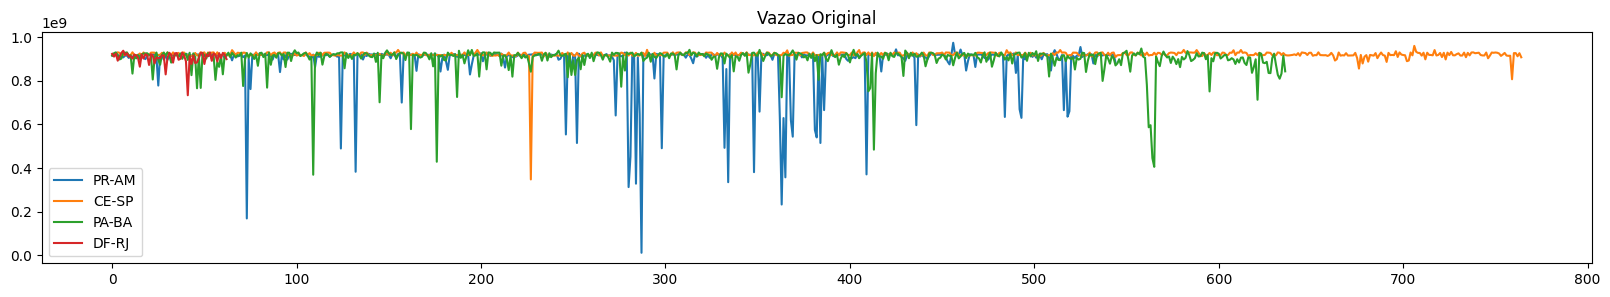

In [18]:
fig, axs = plt.subplots(figsize=(20, 3))

plt.plot(vazao_pr_am_26['Vazao'], label = 'PR-AM')
plt.plot(vazao_ce_sp_26['Vazao'], label = 'CE-SP')
plt.plot(vazao_pa_ba_26['Vazao'], label = 'PA-BA')
plt.plot(vazao_df_rj_26['Vazao'], label = 'DF-RJ')
#plt.plot(vazao_mg_rs['Vazao'])
plt.title('Vazao Original')
plt.legend()

In [19]:
pr_am_preenchido_26_6 = preencher_valores(vazao_pr_am_26)
ce_sp_preenchido_26_6 = preencher_valores(vazao_ce_sp_26)
df_rj_preenchido_26_6 = preencher_valores(vazao_df_rj_26)
pa_ba_preenchido_26_6 = preencher_valores(vazao_pa_ba_26)
mg_rs_preenchido_26_6 = preencher_valores(vazao_mg_rs_26)

pd.set_option('display.float_format', '{:.2f}'.format)

In [20]:
vazao_pr_am_26

Timestamp                Data        Vazao
0    1672787039 2023-01-03 20:03:59 915145436.00
1    1672801714 2023-01-04 00:08:34 919132555.00
2    1672827676 2023-01-04 07:21:16 919132050.00
3    1672852517 2023-01-04 14:15:17 918762107.00
4    1672881864 2023-01-04 22:24:24 900465630.00
..          ...                 ...          ...
540  1687720872 2023-06-25 16:21:12 917922604.00
541  1687757944 2023-06-26 02:39:04 916509639.00
542  1687762173 2023-06-26 03:49:33 919393965.00
543  1687767966 2023-06-26 05:26:06 918969708.00
544  1687781009 2023-06-26 09:03:29 882639995.00

[545 rows x 3 columns]

In [21]:
# Chamando a função para categorizar o horário e criar a nova coluna 'Horario'
df_categorizado = categorize_turno(pr_am_preenchido_26_6)

In [22]:
df_categorizado.head(5)

Timestamp                Data        Vazao  Sintético      Turno
0 1672704791.00 2023-01-03 00:13:11 915145436.00          1  madrugada
1 1672708453.00 2023-01-03 01:14:13 915145436.00          1  madrugada
2 1672712058.00 2023-01-03 02:14:18 915145436.00          1  madrugada
3 1672787039.00 2023-01-03 20:03:59 915145436.00          0      noite
4 1672778959.00 2023-01-03 20:49:19 915145436.00          1      noite

In [23]:
vazao_turno = calculate_mean_vazao_turno(df_categorizado)

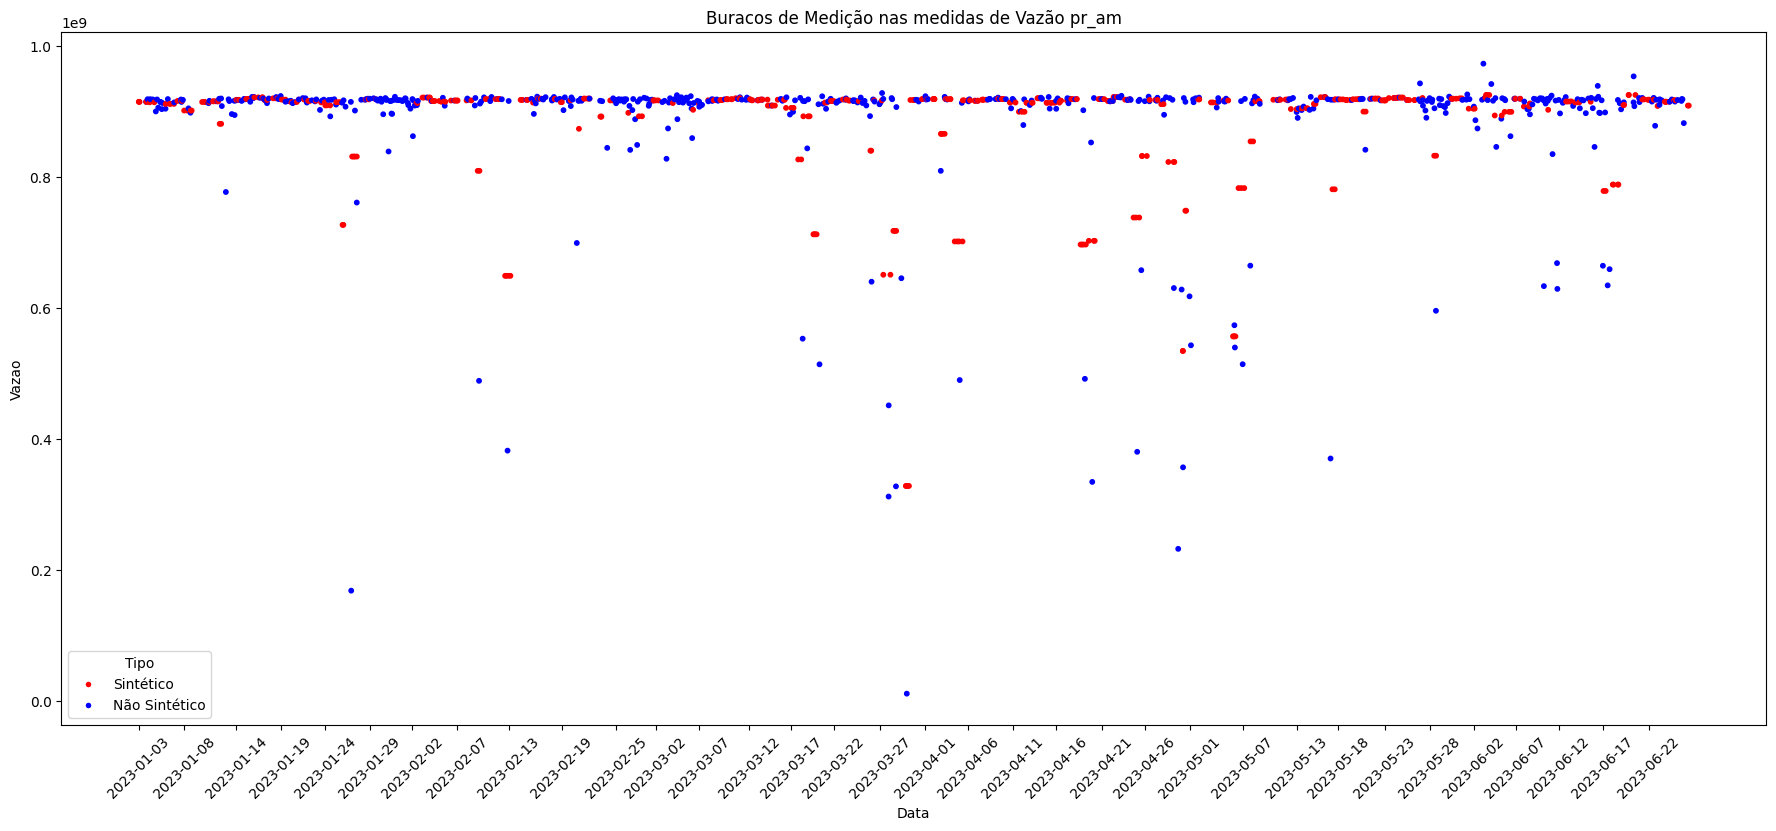

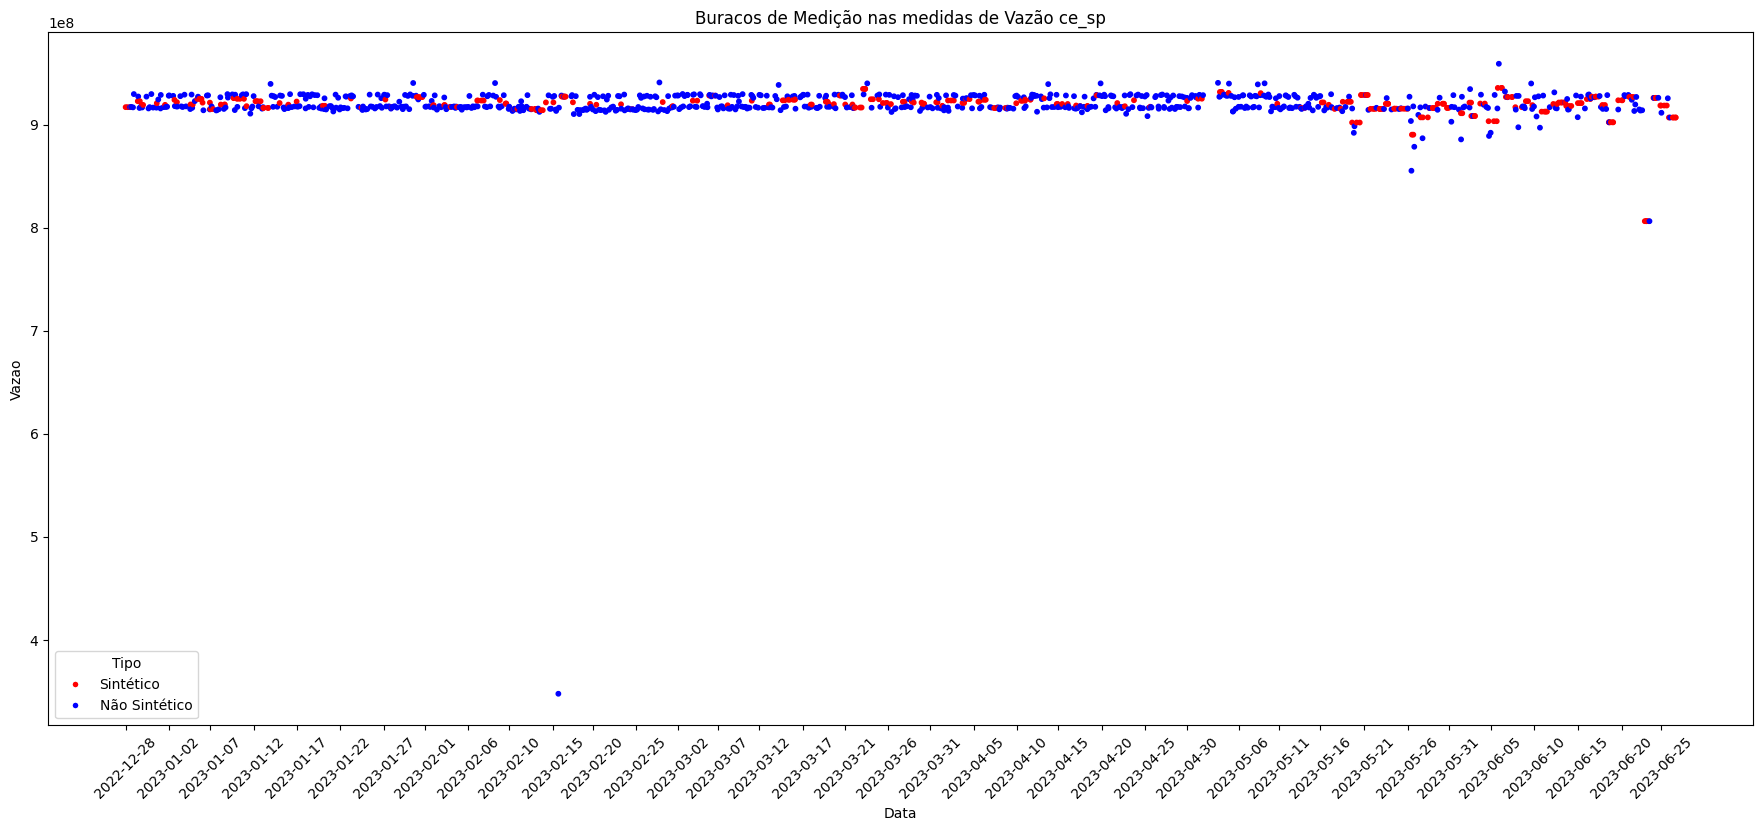

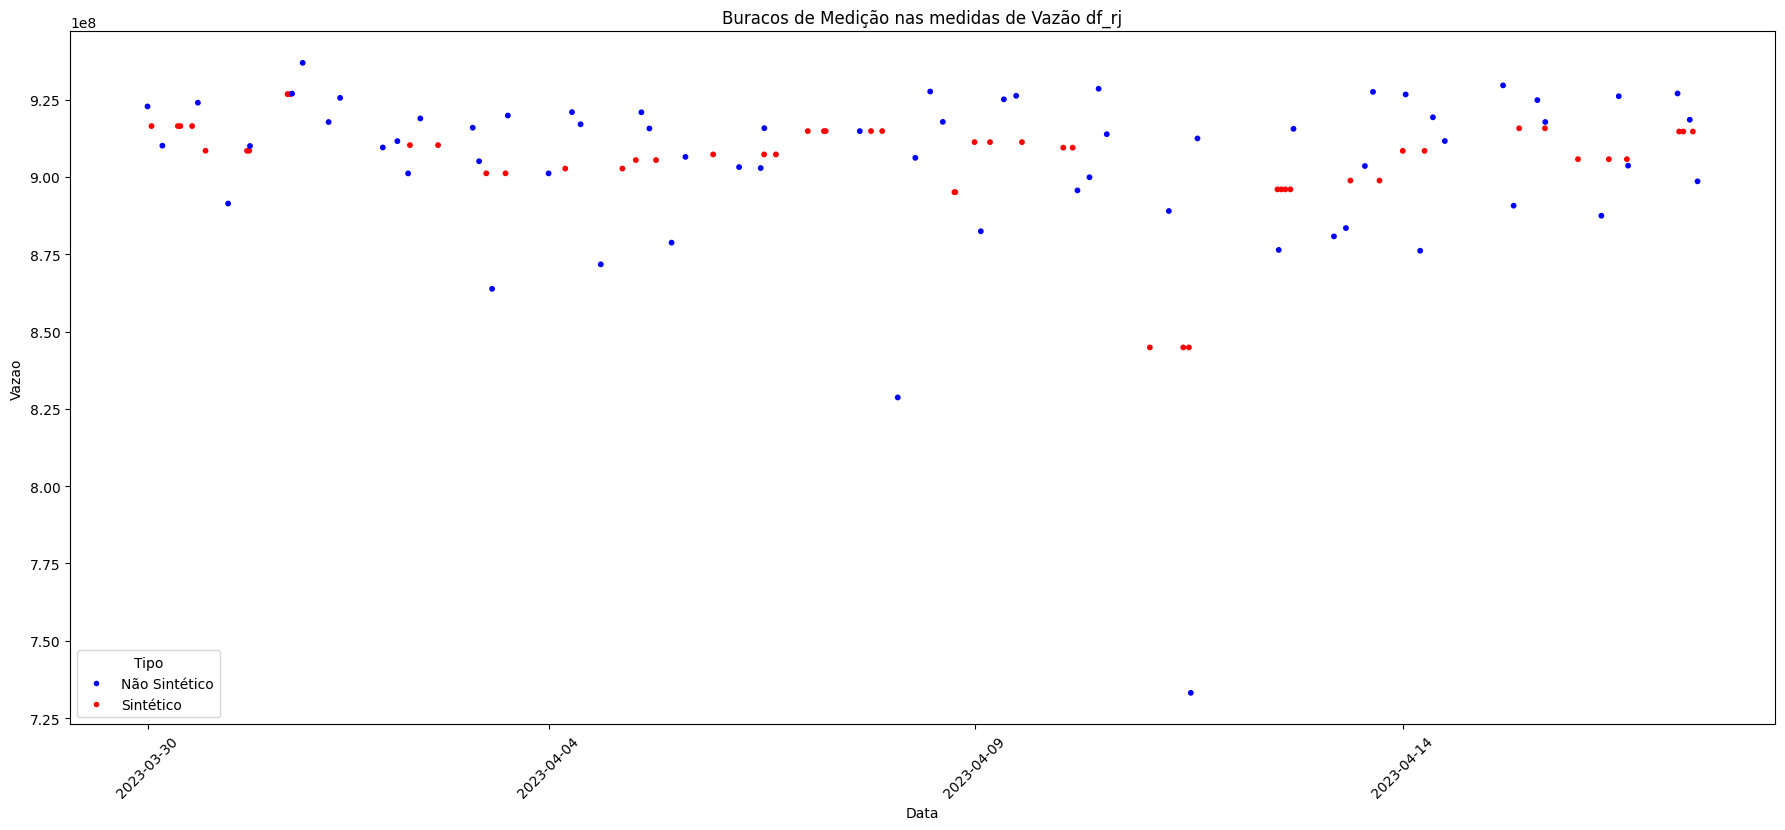

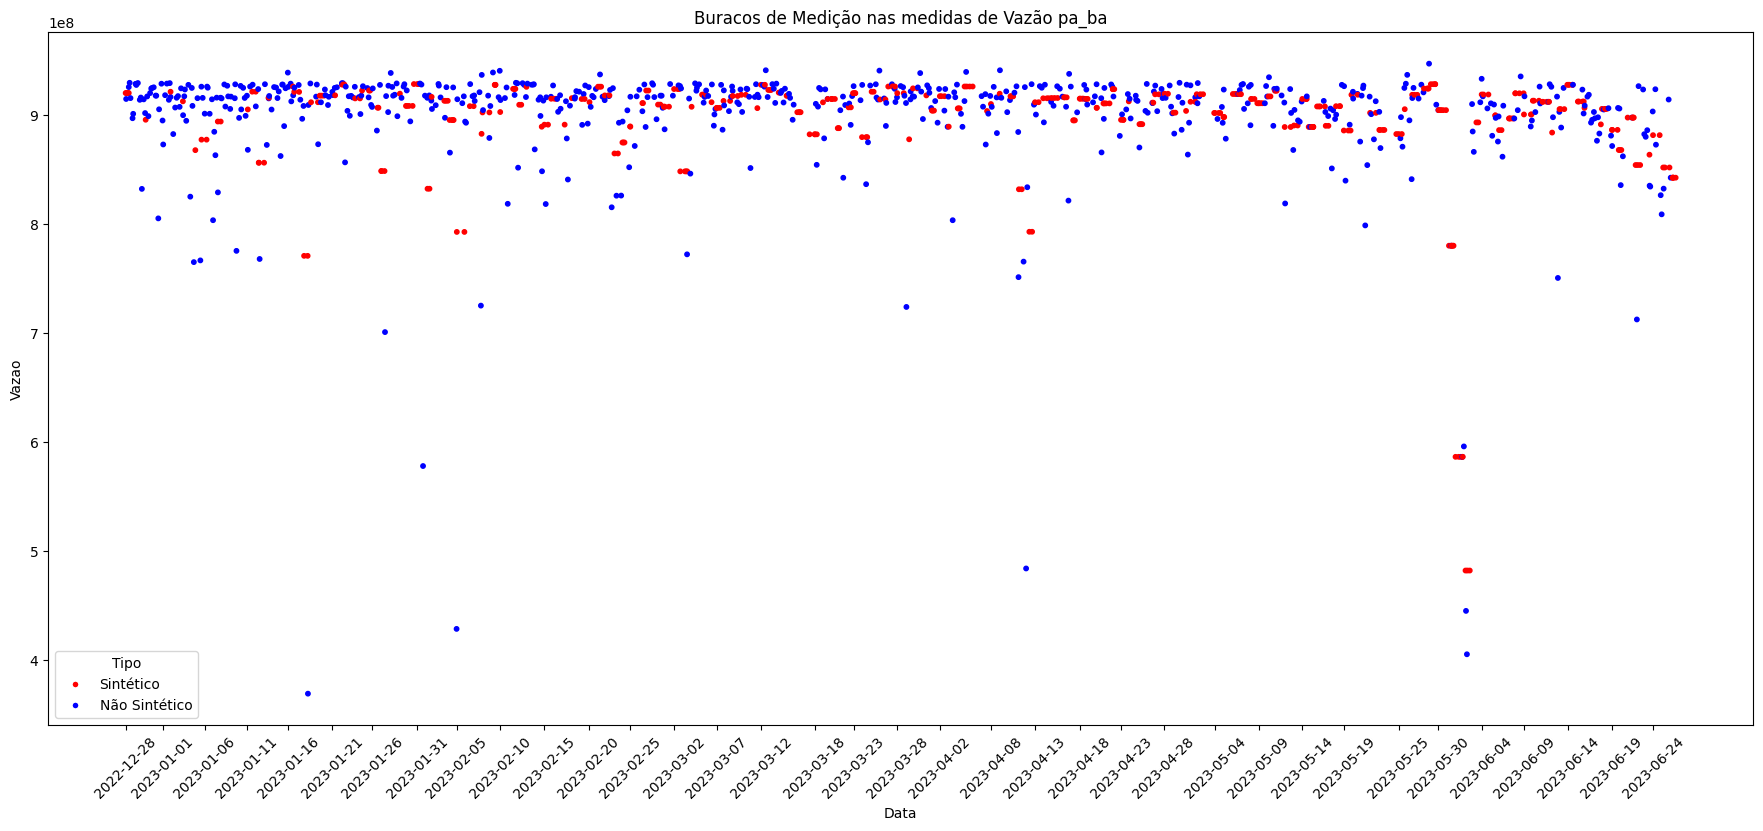

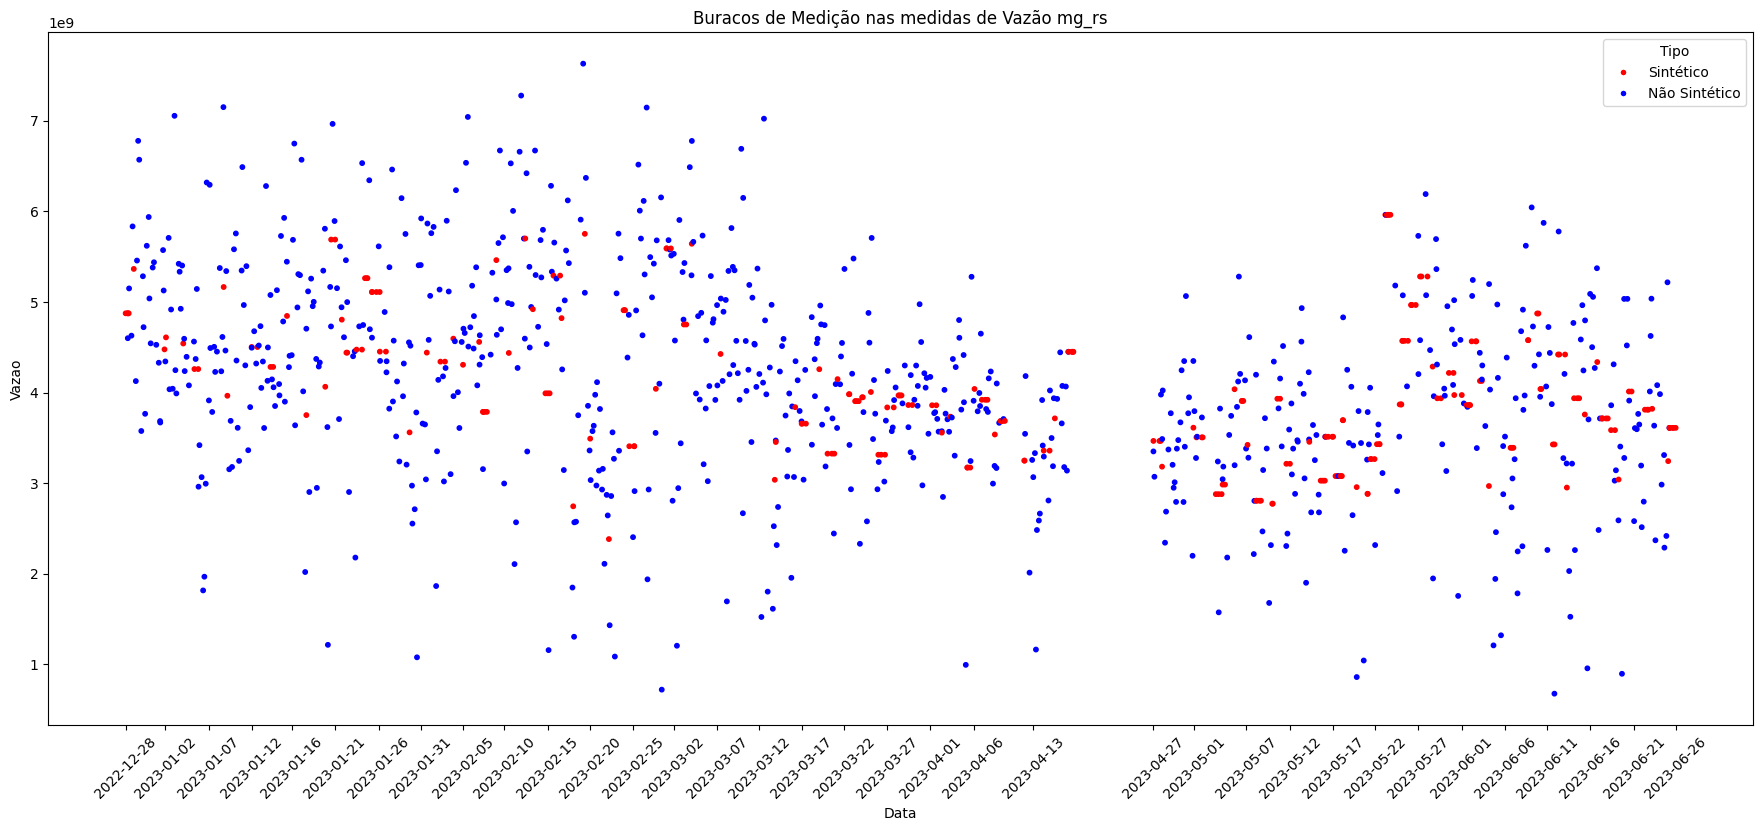

In [24]:
plot_scatter_vazao_tempo(pr_am_preenchido_26_6, 'pr_am_preenchido')
plot_scatter_vazao_tempo(ce_sp_preenchido_26_6, 'ce_sp_preenchido')
plot_scatter_vazao_tempo(df_rj_preenchido_26_6, 'df_rj_preenchido')
plot_scatter_vazao_tempo(pa_ba_preenchido_26_6, 'pa_ba_preenchido')
plot_scatter_vazao_tempo(mg_rs_preenchido_26_6, 'mg_rs_preenchido')

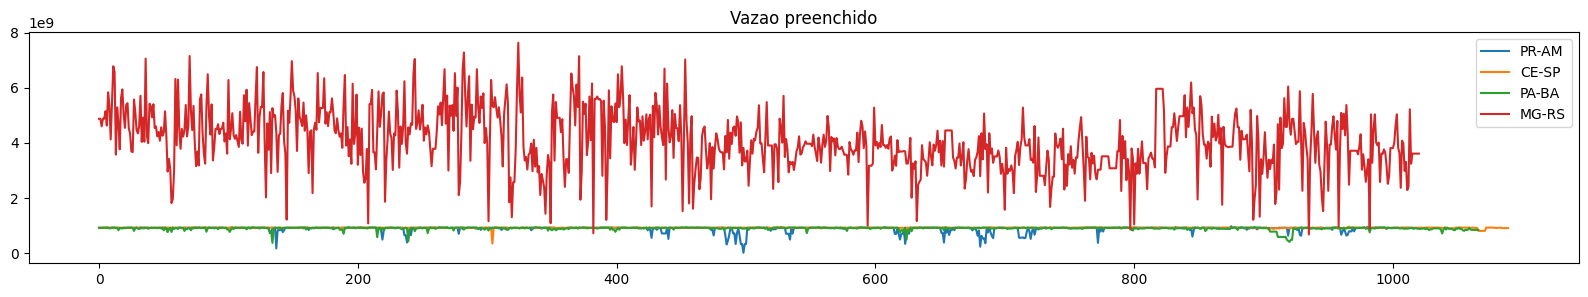

In [25]:
fig, axs = plt.subplots(figsize=(20, 3))

plt.plot(pr_am_preenchido_26_6['Vazao'], label = 'PR-AM')
plt.plot(ce_sp_preenchido_26_6['Vazao'], label = 'CE-SP')
plt.plot(pa_ba_preenchido_26_6['Vazao'], label = 'PA-BA')
#plt.plot(df_rj_preenchido_26_6['Vazao'], label = 'DF-RJ')
plt.plot(mg_rs_preenchido_26_6['Vazao'], label = 'MG-RS')
plt.title('Vazao preenchido')
plt.legend()

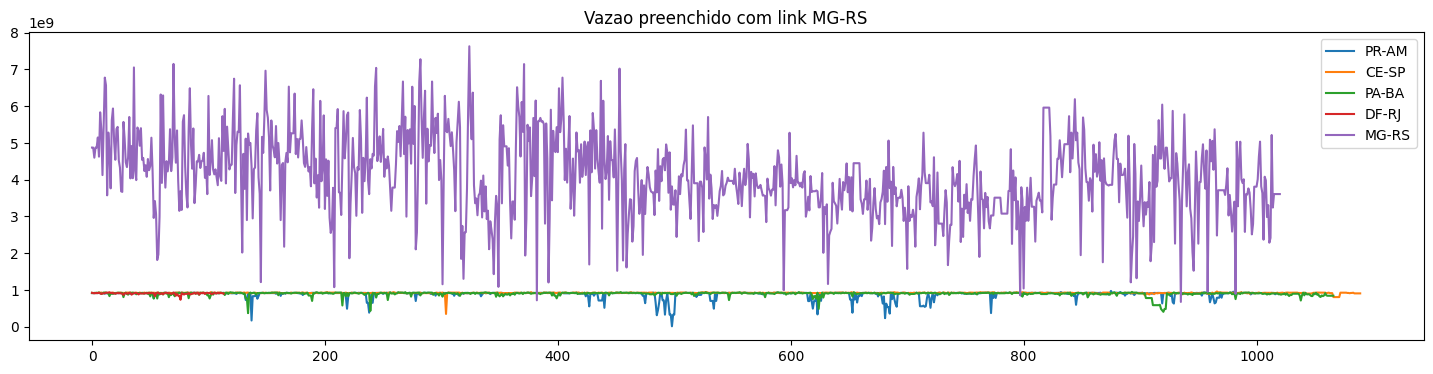

In [26]:
fig, axs = plt.subplots(figsize=(18, 4))

plt.plot(pr_am_preenchido_26_6['Vazao'], label = 'PR-AM')
plt.plot(ce_sp_preenchido_26_6['Vazao'], label = 'CE-SP')
plt.plot(pa_ba_preenchido_26_6['Vazao'], label = 'PA-BA')
plt.plot(df_rj_preenchido_26_6['Vazao'], label = 'DF-RJ')
plt.plot(mg_rs_preenchido_26_6['Vazao'], label = 'MG-RS')
plt.title('Vazao preenchido com link MG-RS')
plt.legend()

### Vazao Original 26/06 - cubic

In [231]:
vazao_pr_am_cubic_26 = pd.read_csv('../datasets/vazao/10-06-2023/tratado/bbr/tratado bbr esmond data pr-am 06-10-2023.csv')
vazao_pa_ba_cubic_26 = pd.read_csv('../datasets/vazao/10-06-2023/tratado/bbr/tratado bbr esmond data pa-ba 06-10-2023.csv')

# vazao_pr_am_cubic_26.head(32)

Data            Intervalo        Vazao
0     12-12-2022  00:00:00 a 06:00:00         -1.0
1     12-12-2022  06:00:00 a 12:00:00         -1.0
2     12-12-2022  12:00:00 a 18:00:00         -1.0
3     12-12-2022  18:00:00 a 23:59:59  928568937.0
4     13-12-2022  00:00:00 a 06:00:00  862089089.0
..           ...                  ...          ...
703     9-6-2023  18:00:00 a 23:59:59  892211527.0
704    10-6-2023  00:00:00 a 06:00:00         -1.0
705    10-6-2023  06:00:00 a 12:00:00  902694338.0
706    10-6-2023  12:00:00 a 18:00:00         -1.0
707    10-6-2023  18:00:00 a 23:59:59         -1.0

[708 rows x 3 columns]

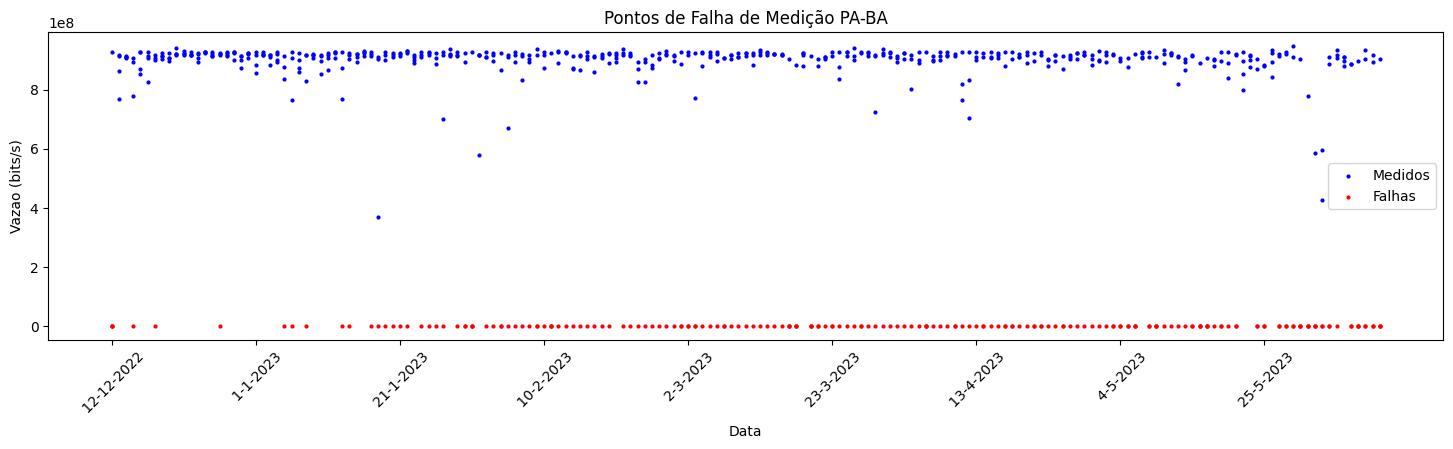

In [227]:
df = vazao_pa_ba_cubic_26

# df = df.iloc[:len(df) // 4]
# df = df.iloc[len(df) // 4:]

# Separe os valores em duas listas: uma para os valores diferentes de -1 e outra para os valores iguais a -1
valores_validos = df[df['Vazao'] != -1]
valores_invalidos = df[df['Vazao'] == -1]

fig, axs = plt.subplots(figsize=(18, 4))

# valores_validos = valores_validos.head(250)
# valores_invalidos = valores_invalidos.head(250)

# Crie um scatter plot com pontos azuis para valores diferentes de -1
plt.scatter(valores_validos['Data'], valores_validos['Vazao'] , c='blue', label='Medidos', s=4)

# Adicione pontos vermelhos para valores iguais a -1
plt.scatter(valores_invalidos['Data'], valores_invalidos['Vazao'], c='red', label='Falhas', s=4)

plt.title('Pontos de Falha de Medição PA-BA')

# Configure outros elementos do gráfico, como rótulos e legenda
plt.xlabel('Data')
plt.ylabel('Vazao (bits/s)')
plt.legend()
plt.xticks(ticks=df['Data'].iloc[::80], rotation=45)


# Exiba o gráfico
plt.show()

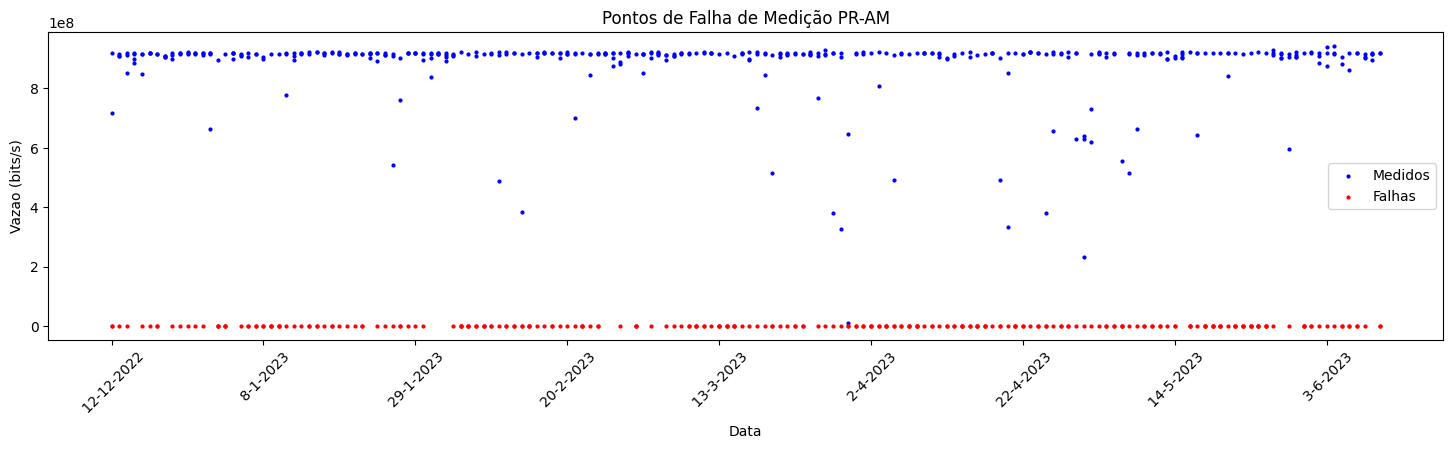

In [228]:
df = vazao_pr_am_cubic_26

# df = df.iloc[:len(df) // 4]
# df = df.iloc[len(df) // 4:]

# Separe os valores em duas listas: uma para os valores diferentes de -1 e outra para os valores iguais a -1
valores_validos = df[df['Vazao'] != -1]
valores_invalidos = df[df['Vazao'] == -1]

fig, axs = plt.subplots(figsize=(18, 4))

# valores_validos = valores_validos.head(250)
# valores_invalidos = valores_invalidos.head(250)

# Crie um scatter plot com pontos azuis para valores diferentes de -1
plt.scatter(valores_validos['Data'], valores_validos['Vazao'] , c='blue', label='Medidos', s=4)

# Adicione pontos vermelhos para valores iguais a -1
plt.scatter(valores_invalidos['Data'], valores_invalidos['Vazao'], c='red', label='Falhas', s=4)

plt.title('Pontos de Falha de Medição PR-AM')

# Configure outros elementos do gráfico, como rótulos e legenda
plt.xlabel('Data')
plt.ylabel('Vazao (bits/s)')
plt.legend()
plt.xticks(ticks=df['Data'].iloc[::80], rotation=45)


# Exiba o gráfico
plt.show()

In [101]:
vazao_pr_am_cubic_26 = pd.read_csv('../datasets/vazao/26-06-2023/original/cubic/cubic esmond data pr-am 06-26-2023.csv', parse_dates=['Data'])
vazao_ce_sp_cubic_26 = pd.read_csv('../datasets/vazao/26-06-2023/original/cubic/cubic esmond data ce-sp 06-26-2023.csv', parse_dates=['Data'])
vazao_df_rj_cubic_26 = pd.read_csv('../datasets/vazao/26-06-2023/original/cubic/cubic esmond data df-rj 06-26-2023.csv', parse_dates=['Data'])
vazao_pa_ba_cubic_26 = pd.read_csv('../datasets/vazao/26-06-2023/original/cubic/cubic esmond data pa-ba 06-26-2023.csv', parse_dates=['Data'])
vazao_mg_rs_cubic_26 = pd.read_csv('../datasets/vazao/26-06-2023/original/cubic/cubic esmond data mg-rs 06-26-2023.csv', parse_dates=['Data'])

In [112]:
vazao_pr_am_cubic_26

Timestamp                Data        Vazao
0    1672800852 2023-01-03 23:54:12   16043227.0
1    1672826682 2023-01-04 07:04:42  831521641.0
2    1672851884 2023-01-04 14:04:44  713715181.0
3    1672878254 2023-01-04 21:24:14  729391179.0
4    1672882955 2023-01-04 22:42:35  639159724.0
..          ...                 ...          ...
500  1687706253 2023-06-25 12:17:33   80014673.0
501  1687723544 2023-06-25 17:05:44  768921934.0
502  1687742361 2023-06-25 22:19:21  452671051.0
503  1687762291 2023-06-26 03:51:31  785860784.0
504  1687773351 2023-06-26 06:55:51  813707303.0

[505 rows x 3 columns]

In [113]:
pr_am_preenchido_cubic_26 = preencher_valores(vazao_pr_am_cubic_26)
ce_sp_preenchido_cubic_26 = preencher_valores(vazao_ce_sp_cubic_26)
df_rj_preenchido_cubic_26 = preencher_valores(vazao_df_rj_cubic_26)
pa_ba_preenchido_cubic_26 = preencher_valores(vazao_pa_ba_cubic_26)
mg_rs_preenchido_cubic_26 = preencher_valores(vazao_mg_rs_cubic_26)

In [114]:
mg_rs_preenchido_cubic_26.head(24)

Timestamp                Data         Vazao  Sintético
0   1.672214e+09 2022-12-28 07:55:38  2.180177e+09          1
1   1.672262e+09 2022-12-28 18:10:03  2.603775e+09          0
2   1.672251e+09 2022-12-28 18:16:31  2.180177e+09          1
3   1.672266e+09 2022-12-28 19:14:32  1.756580e+09          0
4   1.672256e+09 2022-12-28 19:30:45  2.180177e+09          1
5   1.672267e+09 2022-12-28 22:30:11  2.180177e+09          1
6   1.672294e+09 2022-12-29 02:58:29  9.847719e+08          0
7   1.672284e+09 2022-12-29 03:21:20  1.587297e+09          1
8   1.672313e+09 2022-12-29 08:31:32  1.802875e+09          0
9   1.672334e+09 2022-12-29 14:08:50  2.608340e+09          0
10  1.672345e+09 2022-12-29 17:18:01  1.593787e+09          0
11  1.672360e+09 2022-12-29 21:32:07  9.467104e+08          0
12  1.672384e+09 2022-12-30 04:08:52  4.859634e+08          0
13  1.672395e+09 2022-12-30 07:12:19  1.627131e+09          0
14  1.672411e+09 2022-12-30 11:42:00  2.573008e+09          0
15  1.672408e+09 2022-12-30 13:46:56  1.554177e+09          1
16  1.672427e+09 2022-12-30 16:10:37  1.530605e+09          0
17  1.672432e+09 2022-12-30 20:29:26  1.554177e+09          1
18  1.672461e+09 2022-12-31 01:23:32  1.226888e+09          0
19  1.672488e+09 2022-12-31 08:56:45  2.229954e+09          0
20  1.672497e+09 2022-12-31 11:31:45  2.247115e+09          0
21  1.672497e+09 2022-12-31 14:25:54  1.698981e+09          1
22  1.672516e+09 2022-12-31 16:39:06  9.865548e+08          0
23  1.672538e+09 2022-12-31 22:50:00  1.804395e+09          0

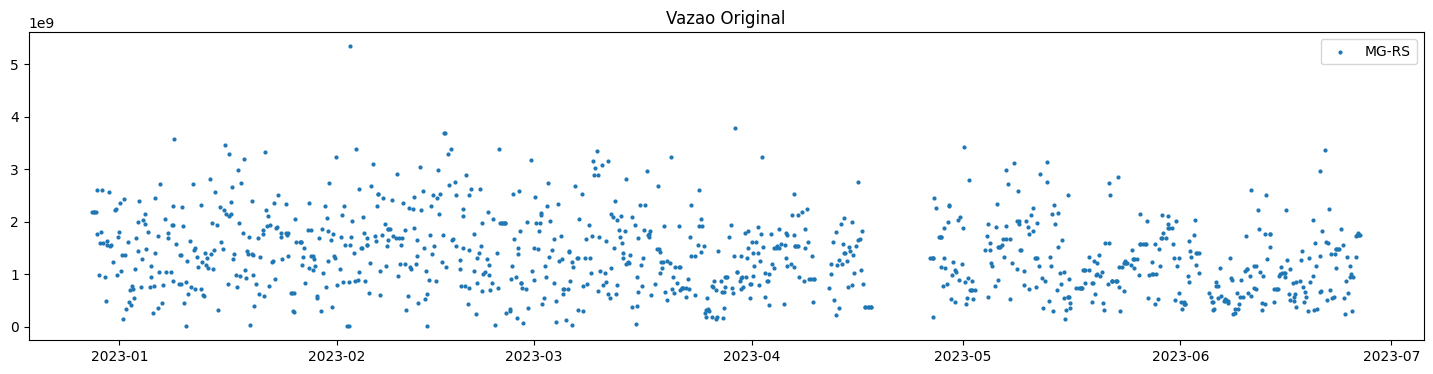

In [104]:
fig, axs = plt.subplots(figsize=(18, 4))

# plt.scatter(pr_am_preenchido_cubic_26['Data'], pr_am_preenchido_cubic_26['Vazao'],label = 'PR-AM', s=4)
# plt.scatter(ce_sp_preenchido_cubic_26['Data'],ce_sp_preenchido_cubic_26['Vazao'], label = 'CE-SP', s=4)
# plt.scatter(pa_ba_preenchido_cubic_26['Data'],pa_ba_preenchido_cubic_26['Vazao'], label = 'PA-BA', s=4)
# plt.scatter(pr_am_preenchido_cubic_26['Vazao'],pr_am_preenchido_cubic_26t.
plt.scatter(mg_rs_preenchido_cubic_26['Data'],mg_rs_preenchido_cubic_26['Vazao'], label = 'MG-RS', s=4)

plt.title('Vazao Original')
plt.legend()

In [91]:
df

Timestamp                Data         Vazao  Sintético
31   1.673147e+09 2023-01-08 03:05:52  6.927415e+08          1
32   1.673154e+09 2023-01-08 04:57:35  6.927415e+08          1
33   1.673180e+09 2023-01-08 12:13:31  6.927415e+08          1
34   1.673211e+09 2023-01-08 17:52:05  6.927415e+08          0
35   1.673206e+09 2023-01-08 19:20:50  6.927415e+08          1
..            ...                 ...           ...        ...
121  1.674550e+09 2023-01-24 05:41:24  6.002050e+08          0
122  1.674585e+09 2023-01-24 15:27:43  7.610053e+08          0
123  1.674609e+09 2023-01-24 22:13:37  6.174024e+08          0
124  1.674599e+09 2023-01-24 22:29:50  6.824405e+08          1
125  1.674613e+09 2023-01-24 23:19:25  7.511493e+08          0

[95 rows x 4 columns]

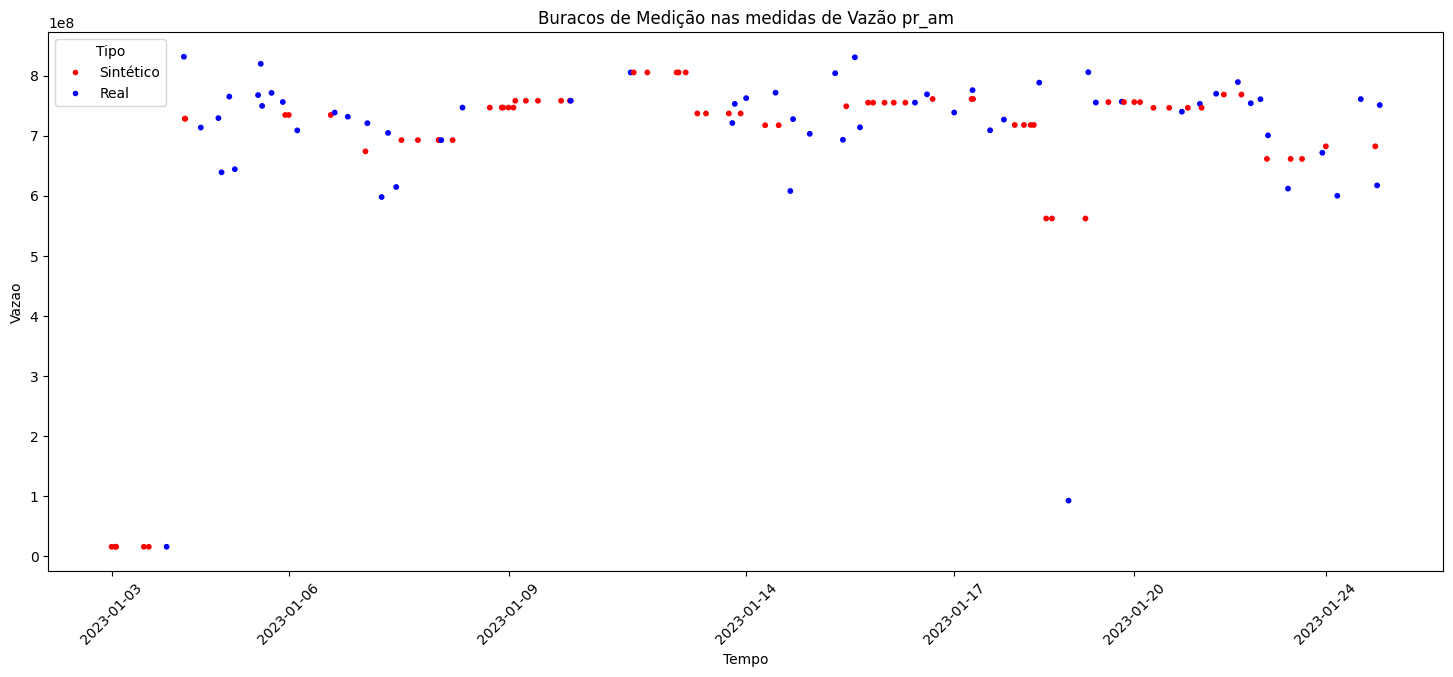

In [110]:
df = pr_am_preenchido_cubic_26.iloc[:len(pr_am_preenchido_cubic_26) // 2]

df = df.iloc[:len(df) // 4]


plot_scatter_vazao_tempo(df, 'pr_am_preenchido')


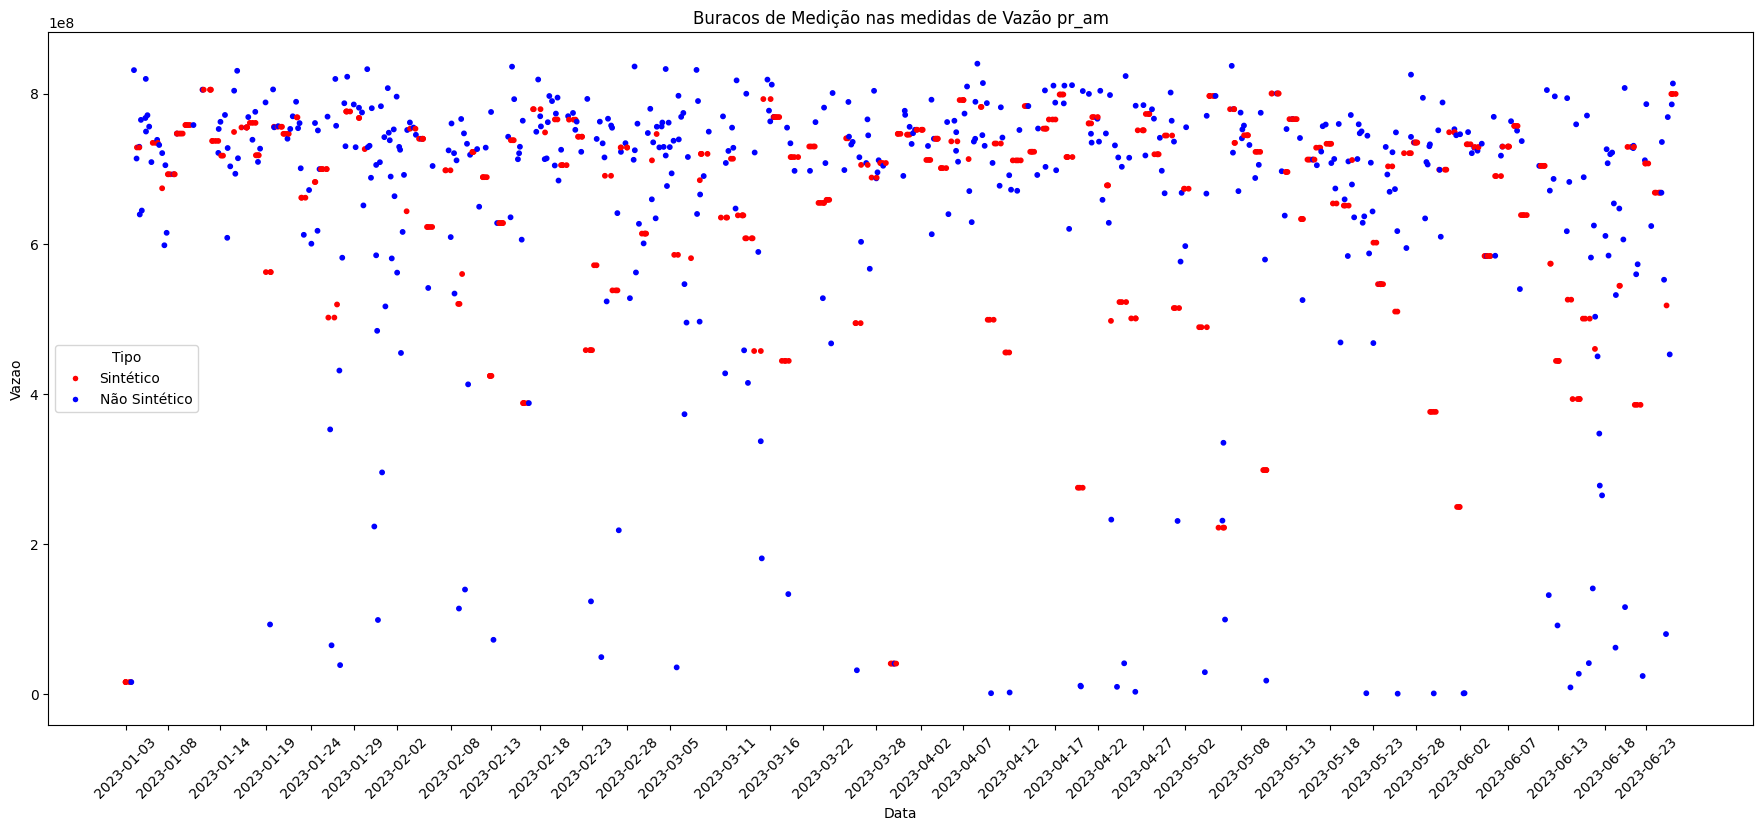

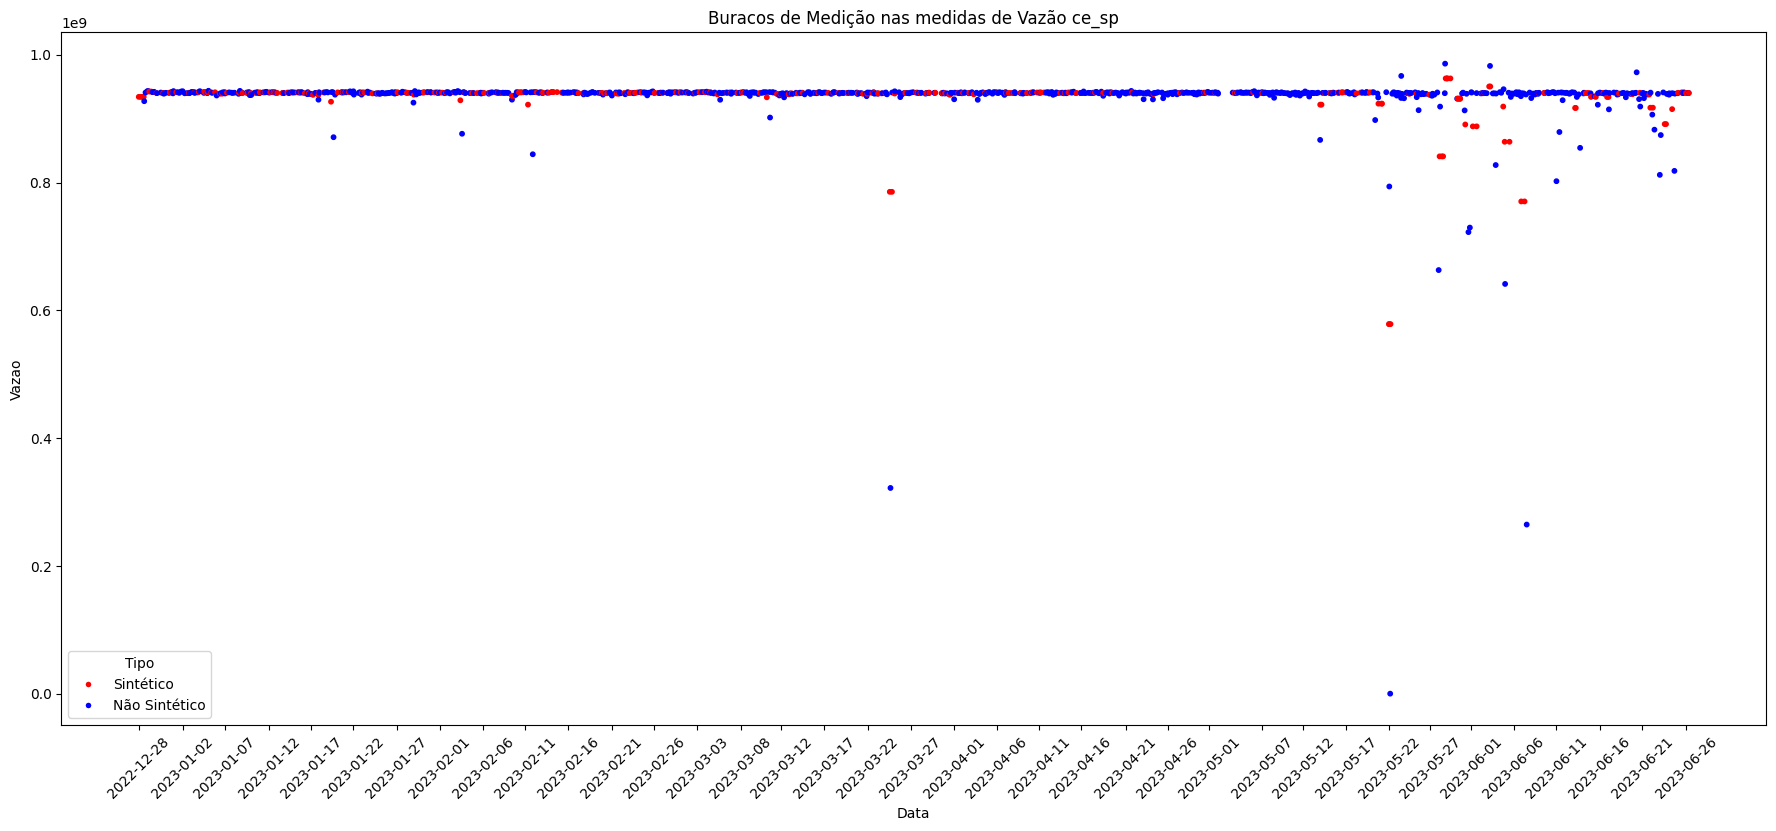

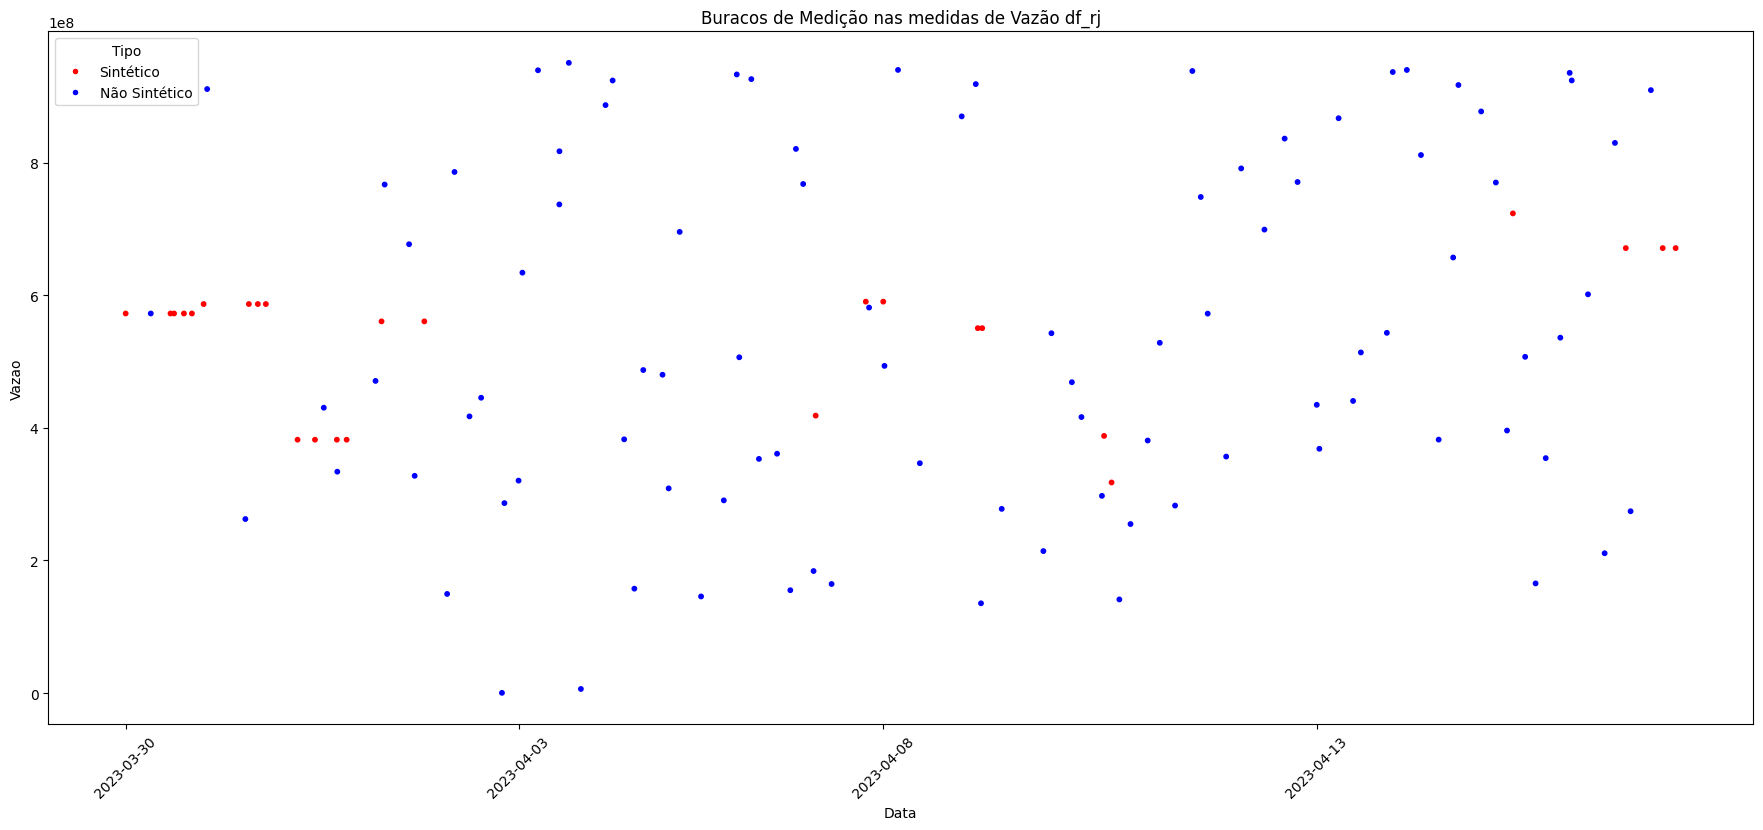

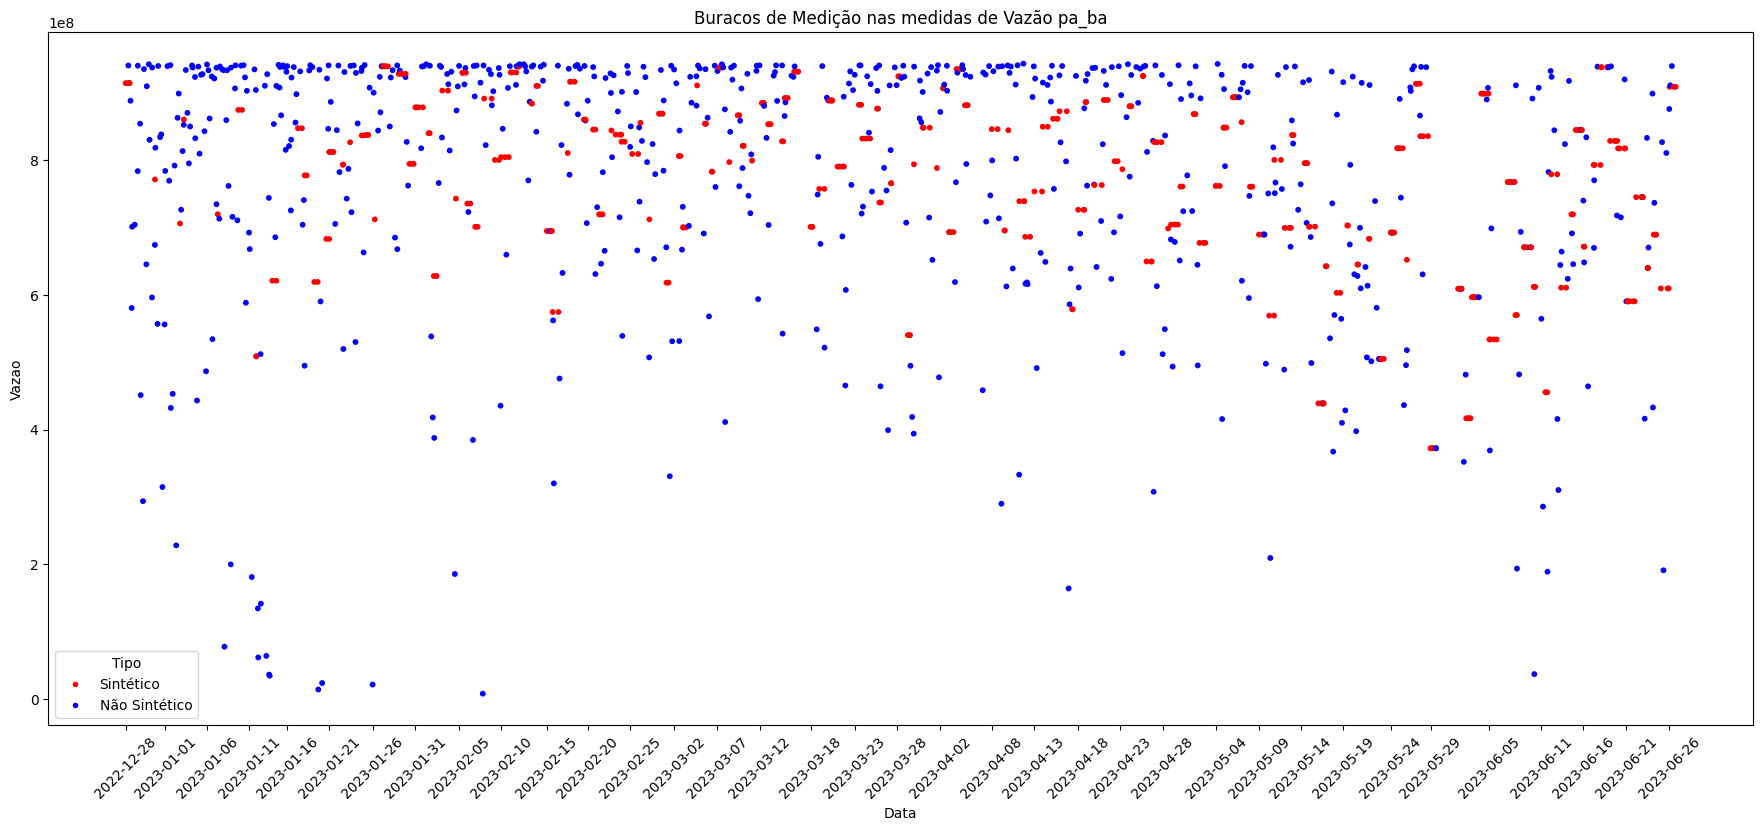

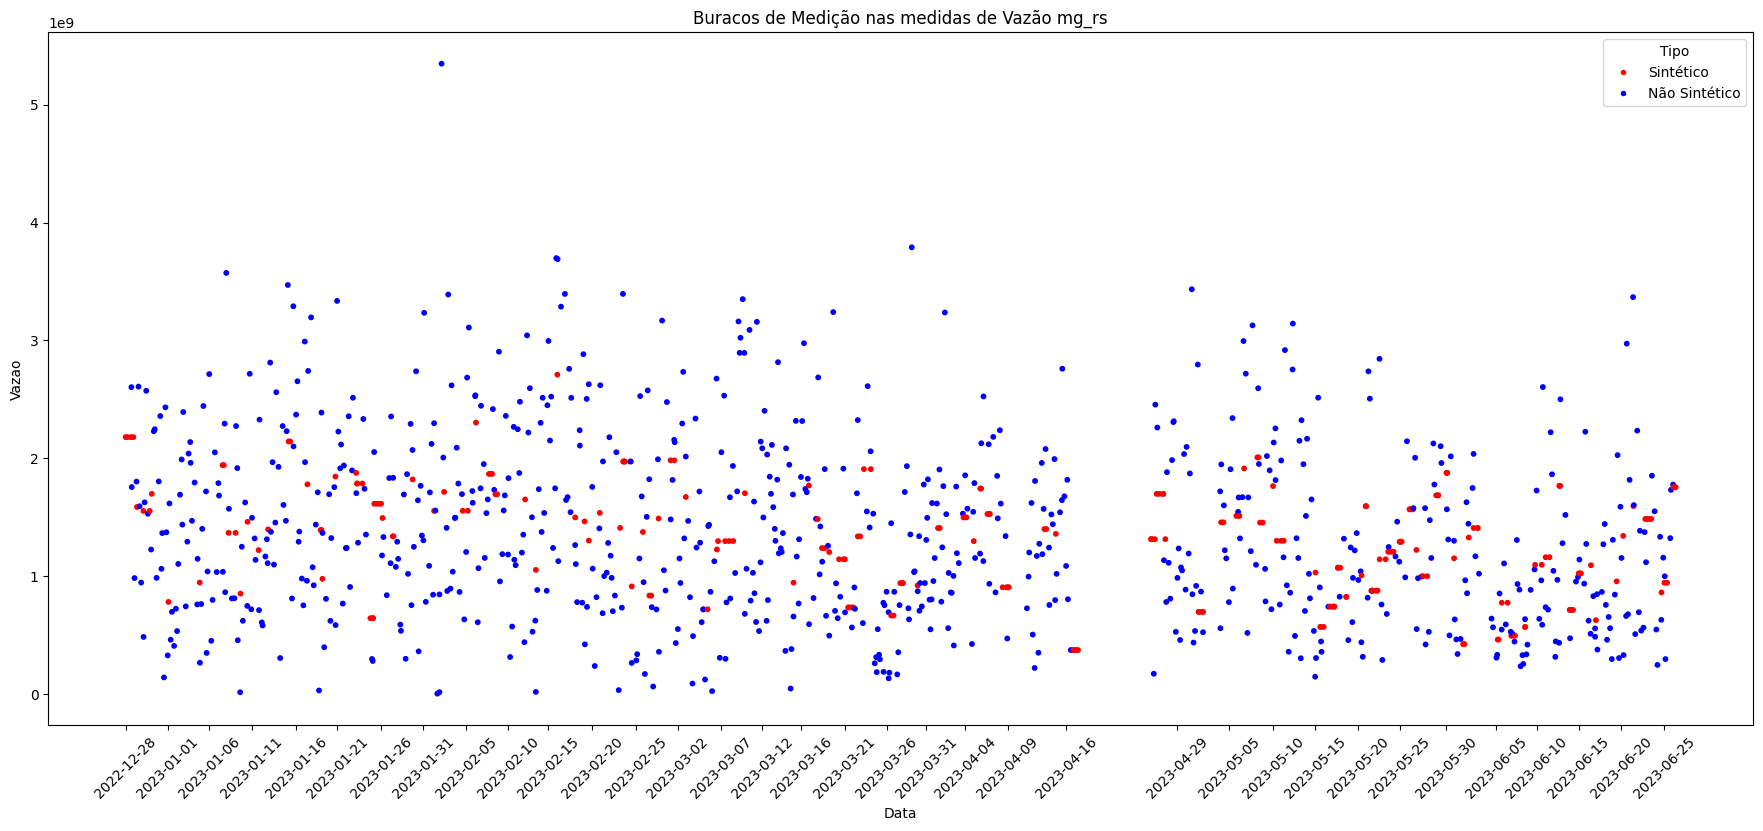

In [41]:
plot_scatter_vazao_tempo(pr_am_preenchido_cubic_26, 'pr_am_preenchido')
plot_scatter_vazao_tempo(ce_sp_preenchido_cubic_26, 'ce_sp_preenchido')
plot_scatter_vazao_tempo(df_rj_preenchido_cubic_26, 'df_rj_preenchido')
plot_scatter_vazao_tempo(pa_ba_preenchido_cubic_26, 'pa_ba_preenchido')
plot_scatter_vazao_tempo(mg_rs_preenchido_cubic_26, 'mg_rs_preenchido')

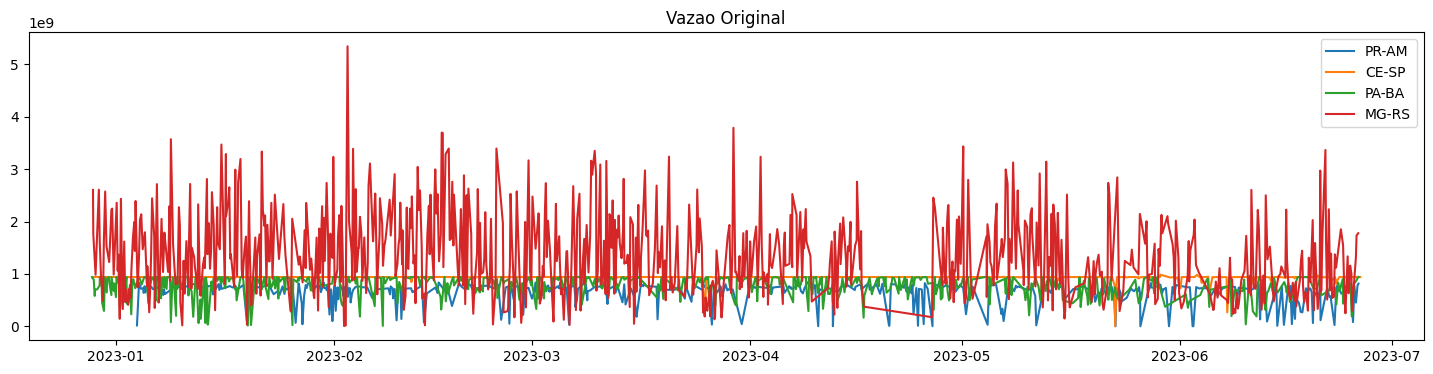

In [23]:
fig, axs = plt.subplots(figsize=(18, 4))

plt.plot(vazao_pr_am_cubic_26['Data'], vazao_pr_am_cubic_26['Vazao'],label = 'PR-AM')
plt.plot(vazao_ce_sp_cubic_26['Data'],vazao_ce_sp_cubic_26['Vazao'], label = 'CE-SP')
plt.plot(vazao_pa_ba_cubic_26['Data'],vazao_pa_ba_cubic_26['Vazao'], label = 'PA-BA')
# plt.plot(vazao_df_rj_cubic_26['Vazao'], label = 'DF-RJ')
plt.plot(vazao_mg_rs_cubic_26['Data'],vazao_mg_rs_cubic_26['Vazao'], label = 'MG-RS')

plt.title('Vazao Original')
plt.legend()

### Vazao Original 10/06 - cubic

In [34]:
vazao_pr_am_cubic = pd.read_csv('../datasets/vazao/10-06-2023/original/cubic/cubic esmond data pr-am 06-10-2023.csv',names=['Timestamp', 'Data', 'Vazao'], parse_dates=['Data'])
vazao_ce_sp_cubic = pd.read_csv('../datasets/vazao/10-06-2023/original/cubic/cubic esmond data ce-sp 06-10-2023.csv',names=['Timestamp', 'Data', 'Vazao'], parse_dates=['Data'])
vazao_df_rj_cubic = pd.read_csv('../datasets/vazao/10-06-2023/original/cubic/cubic esmond data df-rj 06-10-2023.csv',names=['Timestamp', 'Data', 'Vazao'], parse_dates=['Data'])
vazao_pa_ba_cubic = pd.read_csv('../datasets/vazao/10-06-2023/original/cubic/cubic esmond data pa-ba 06-10-2023.csv',names=['Timestamp', 'Data', 'Vazao'], parse_dates=['Data'])
vazao_mg_rs_cubic = pd.read_csv('../datasets/vazao/10-06-2023/original/cubic/cubic esmond data mg-rs 06-10-2023.csv',names=['Timestamp', 'Data', 'Vazao'], parse_dates=['Data'])

In [35]:
pr_am_preenchido_cubic = preencher_valores(vazao_pr_am_cubic)
ce_sp_preenchido_cubic = preencher_valores(vazao_ce_sp_cubic)
df_rj_preenchido_cubic = preencher_valores(vazao_df_rj_cubic)
pa_ba_preenchido_cubic = preencher_valores(vazao_pa_ba_cubic)
mg_rs_preenchido_cubic = preencher_valores(vazao_mg_rs_cubic)

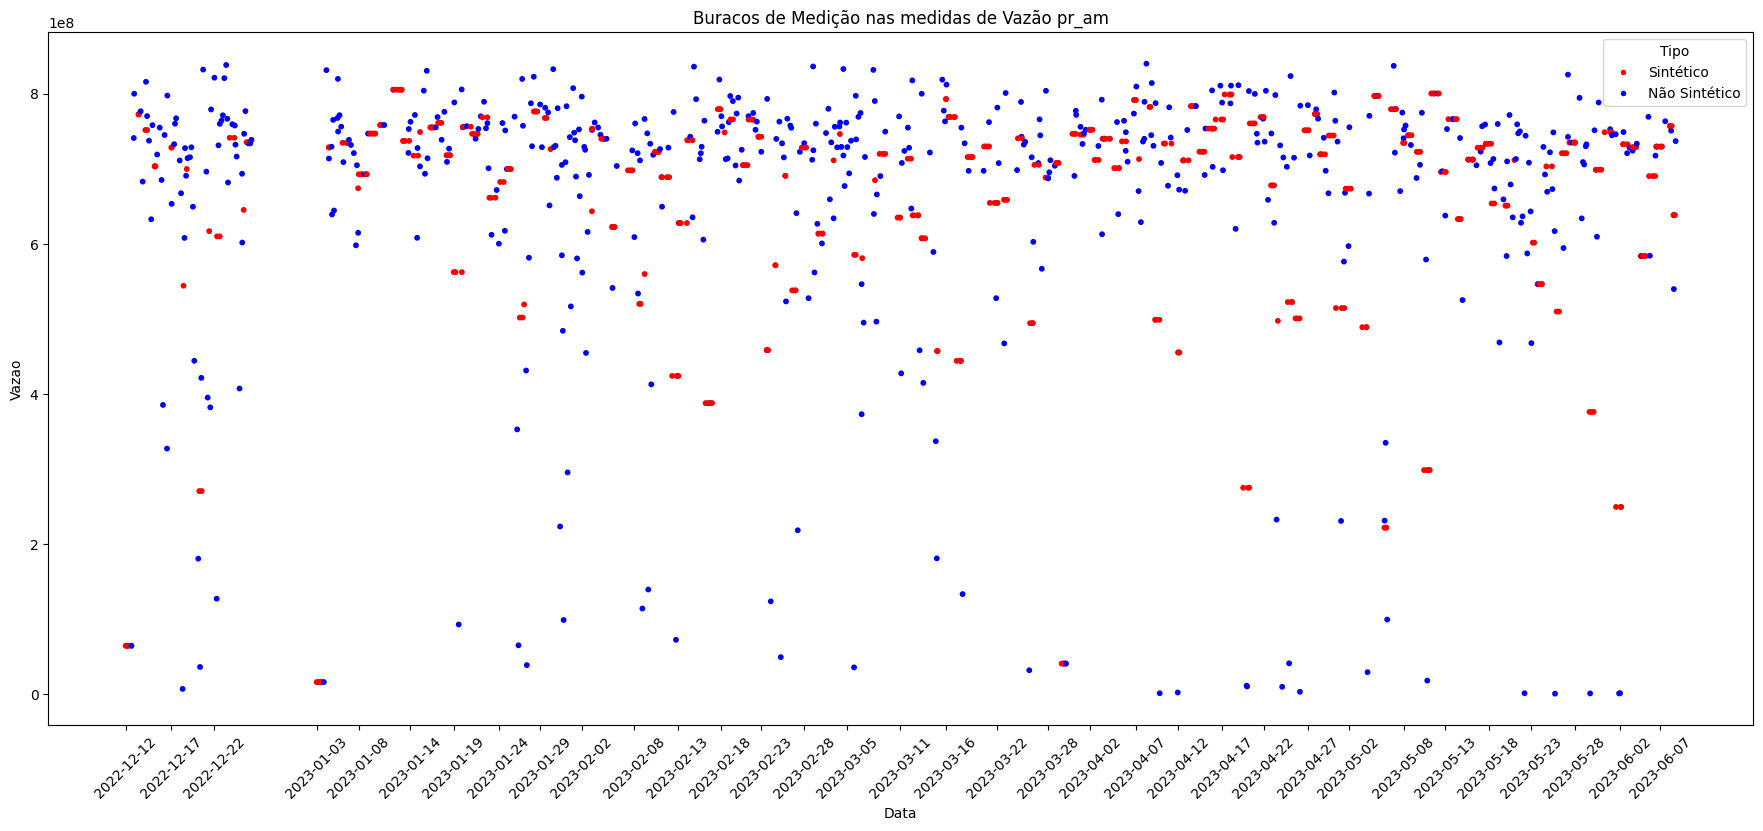

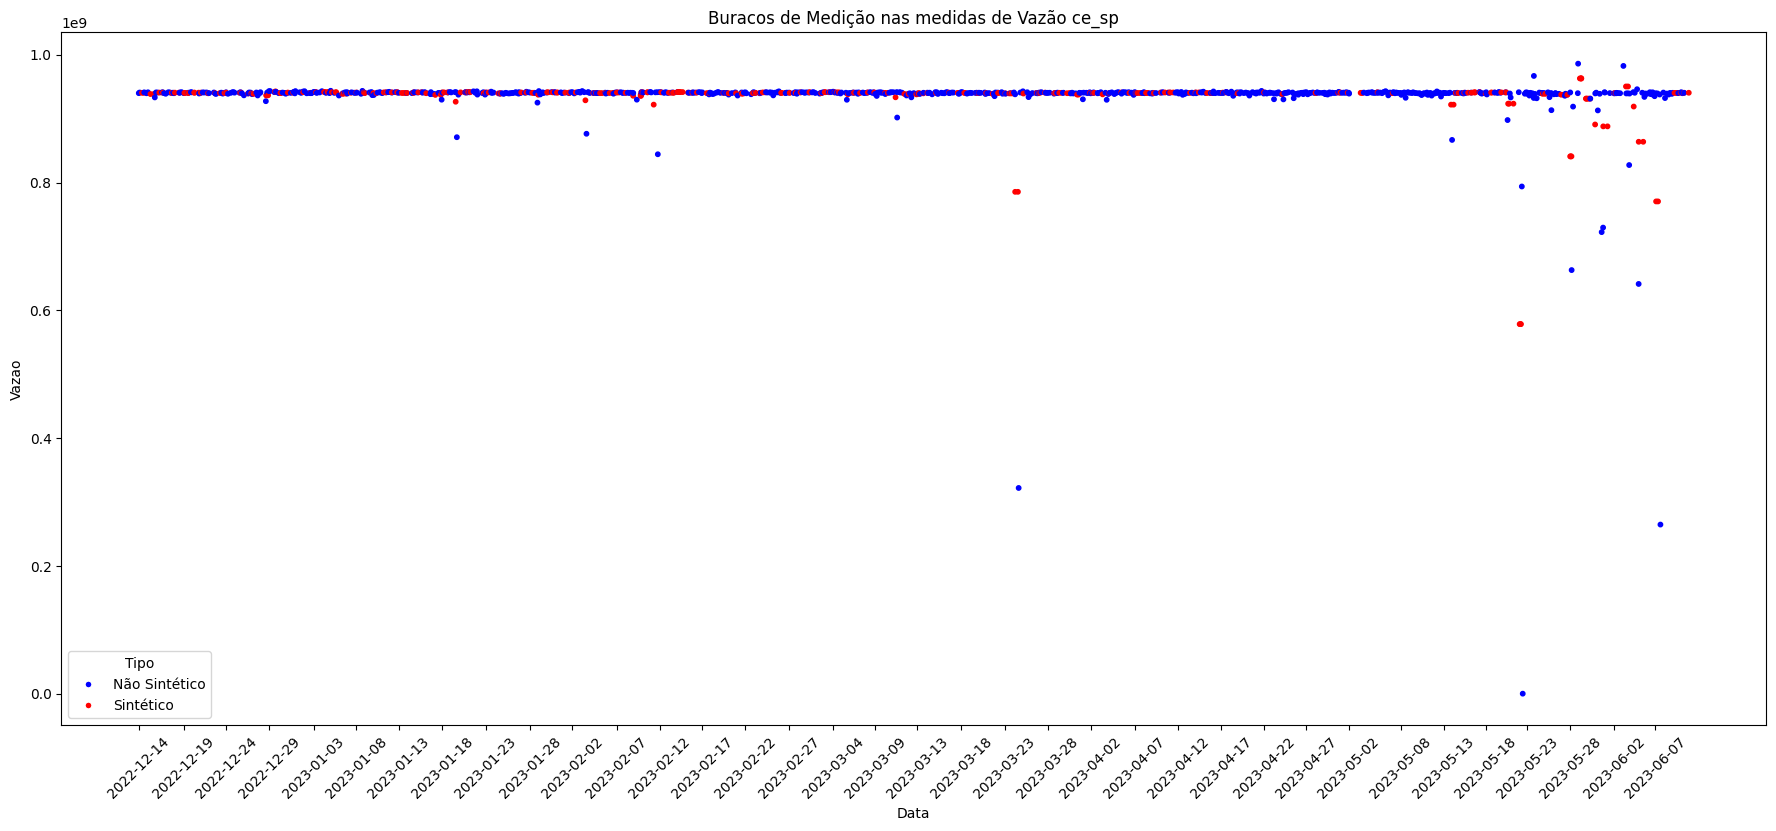

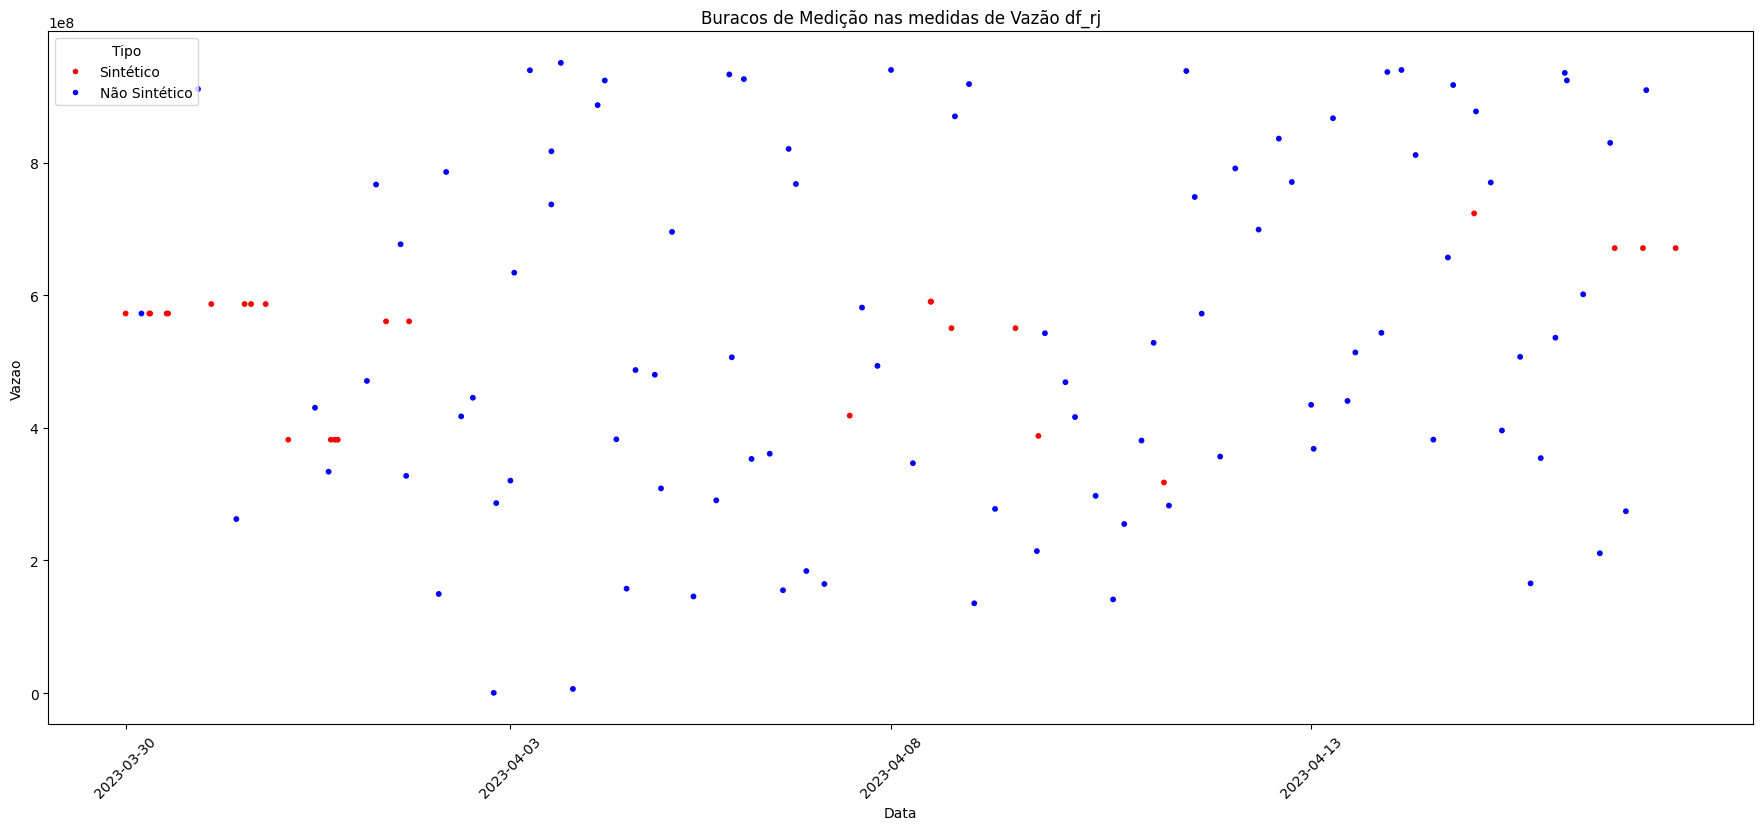

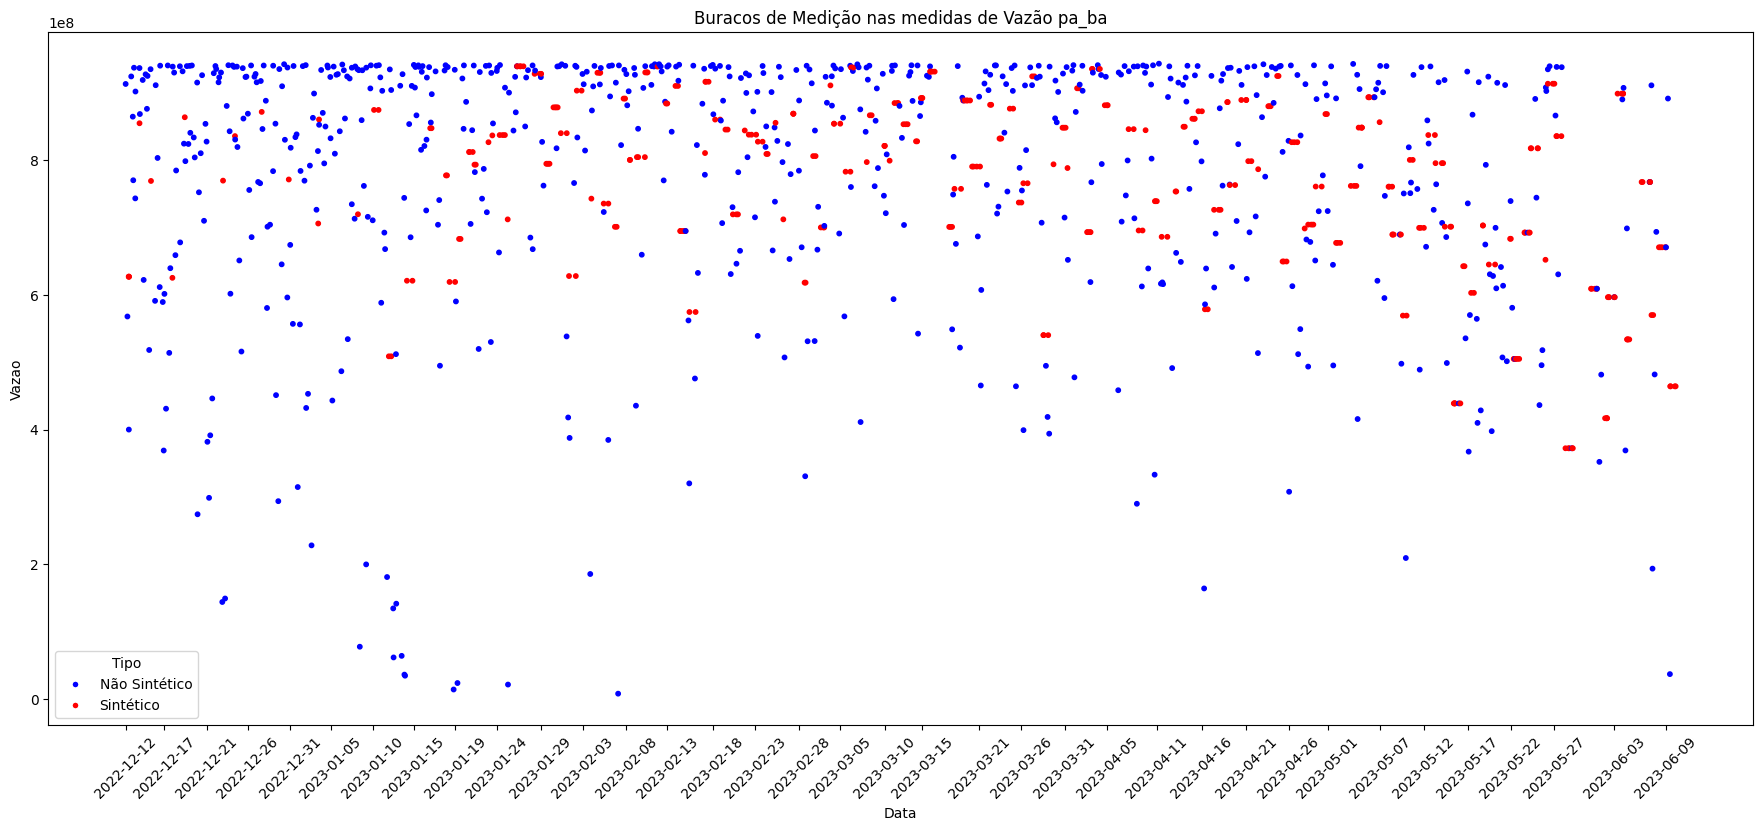

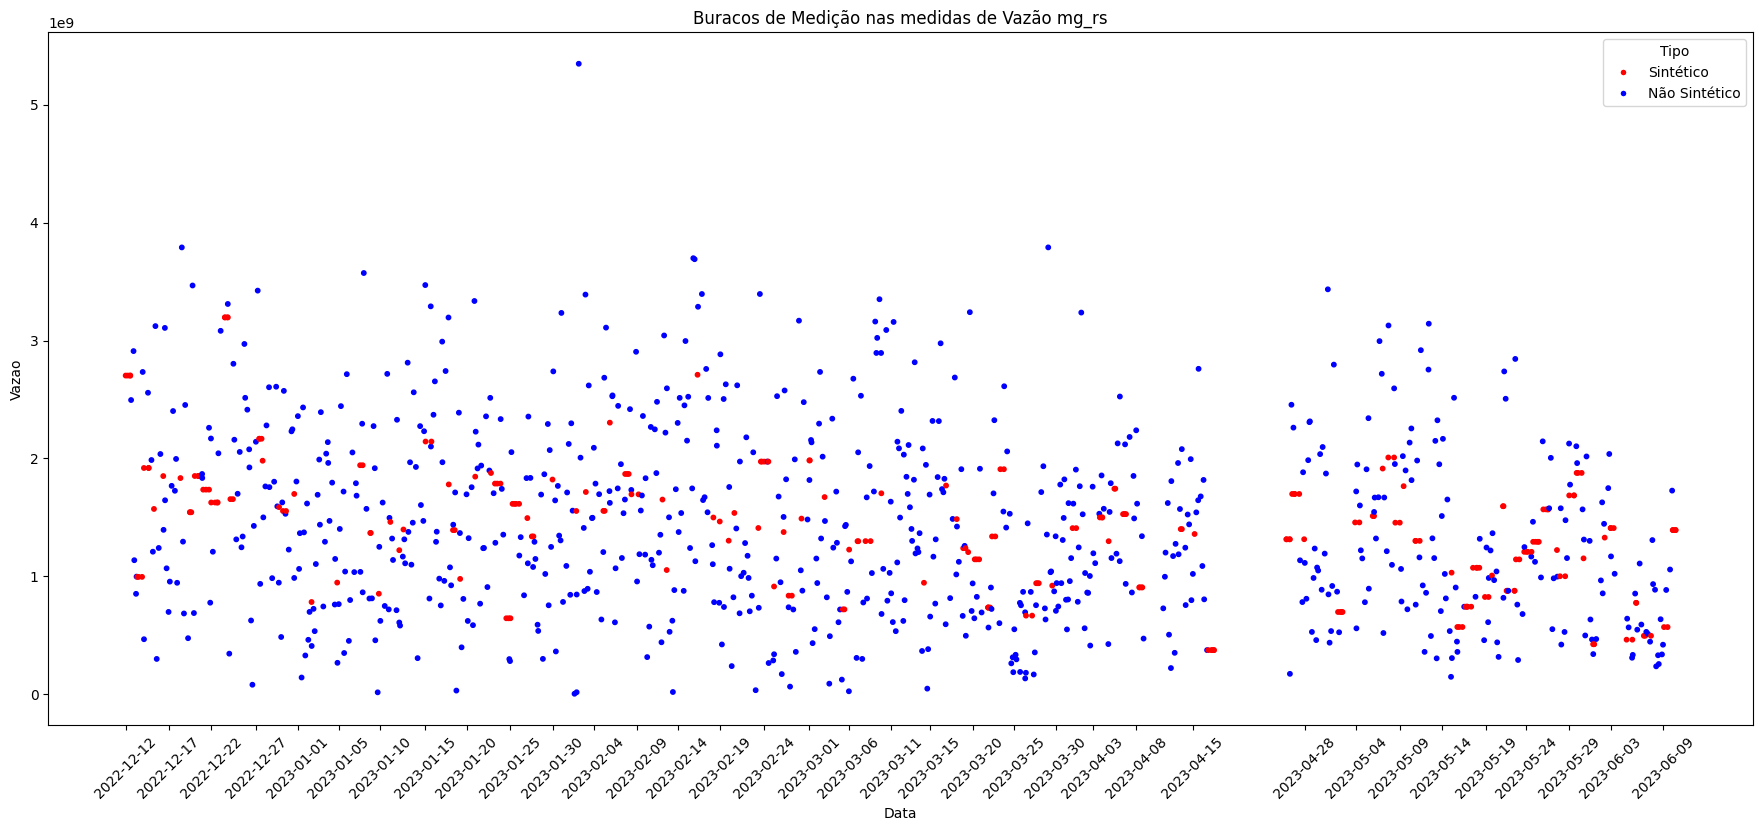

In [36]:
plot_scatter_vazao_tempo(pr_am_preenchido_cubic, 'pr_am_preenchido')
plot_scatter_vazao_tempo(ce_sp_preenchido_cubic, 'ce_sp_preenchido')
plot_scatter_vazao_tempo(df_rj_preenchido_cubic, 'df_rj_preenchido')
plot_scatter_vazao_tempo(pa_ba_preenchido_cubic, 'pa_ba_preenchido')
plot_scatter_vazao_tempo(mg_rs_preenchido_cubic, 'mg_rs_preenchido')

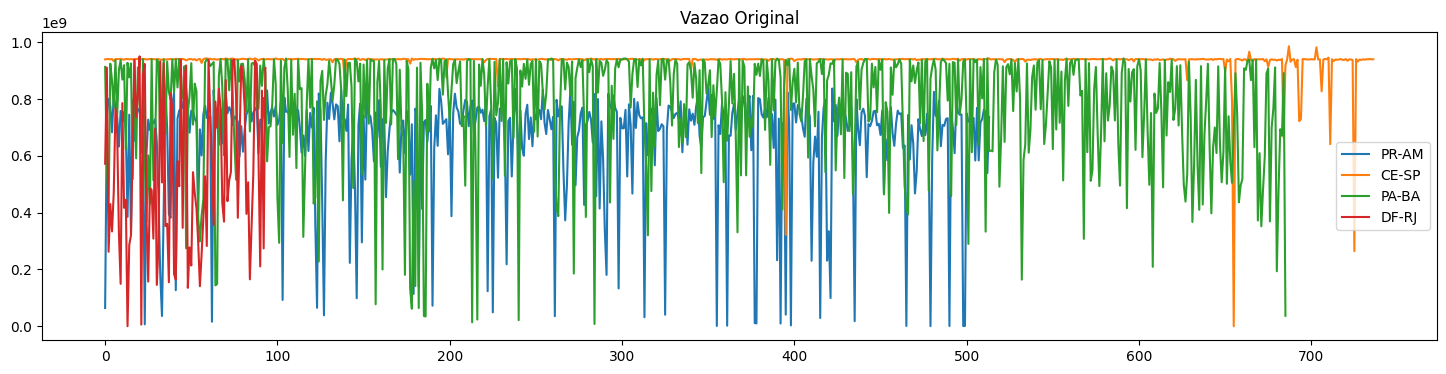

In [37]:
fig, axs = plt.subplots(figsize=(18, 4))

plt.plot(vazao_pr_am_cubic['Vazao'], label = 'PR-AM')
plt.plot(vazao_ce_sp_cubic['Vazao'], label = 'CE-SP')
plt.plot(vazao_pa_ba_cubic['Vazao'], label = 'PA-BA')
plt.plot(vazao_df_rj_cubic['Vazao'], label = 'DF-RJ')
#plt.plot(mg_rs_preenchido_cubic['Vazao'], label = 'MG-RS')
plt.title('Vazao Original')
plt.legend()

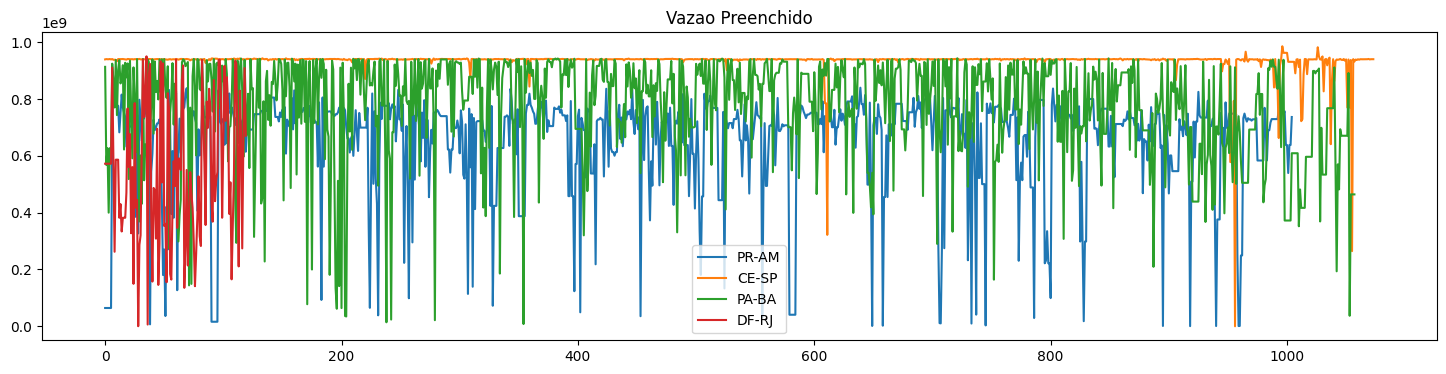

In [38]:
fig, axs = plt.subplots(figsize=(18, 4))

plt.plot(pr_am_preenchido_cubic['Vazao'], label = 'PR-AM')
plt.plot(ce_sp_preenchido_cubic['Vazao'], label = 'CE-SP')
plt.plot(pa_ba_preenchido_cubic['Vazao'], label = 'PA-BA')
plt.plot(df_rj_preenchido_cubic['Vazao'], label = 'DF-RJ')
#plt.plot(mg_rs_preenchido_cubic['Vazao'], label = 'MG-RS')
plt.title('Vazao Preenchido')
plt.legend()

### Vazao Original 10/06 - bbr

In [39]:
vazao_pr_am = pd.read_csv('../datasets/vazao/10-06-2023/original/bbr/bbr esmond data pr-am 06-10-2023.csv',names=['Timestamp', 'Data', 'Vazao'], parse_dates=['Data'])
vazao_ce_sp = pd.read_csv('../datasets/vazao/10-06-2023/original/bbr/bbr esmond data ce-sp 06-10-2023.csv',names=['Timestamp', 'Data', 'Vazao'], parse_dates=['Data'])
vazao_df_rj = pd.read_csv('../datasets/vazao/10-06-2023/original/bbr/bbr esmond data df-rj 06-10-2023.csv',names=['Timestamp', 'Data', 'Vazao'], parse_dates=['Data'])
vazao_pa_ba = pd.read_csv('../datasets/vazao/10-06-2023/original/bbr/bbr esmond data pa-ba 06-10-2023.csv',names=['Timestamp', 'Data', 'Vazao'], parse_dates=['Data'])
vazao_mg_rs = pd.read_csv('../datasets/vazao/10-06-2023/original/bbr/bbr esmond data mg-rs 06-10-2023.csv',names=['Timestamp', 'Data', 'Vazao'], parse_dates=['Data'])

In [40]:
pr_am_preenchido = preencher_valores(vazao_pr_am)
ce_sp_preenchido = preencher_valores(vazao_ce_sp)
df_rj_preenchido = preencher_valores(vazao_df_rj)
pa_ba_preenchido = preencher_valores(vazao_pa_ba)
mg_rs_preenchido = preencher_valores(vazao_mg_rs)

In [41]:
pr_am_preenchido.head(20)

Timestamp                Data        Vazao  Sintético
0  1670826988.00 2022-12-12 06:36:28 818138534.75          1
1  1670860475.00 2022-12-12 12:54:35 921225339.00          0
2  1670874991.00 2022-12-12 16:56:31 514589135.00          0
3  1670887938.00 2022-12-12 20:32:18 918815822.00          0
4  1670885659.00 2022-12-12 22:54:19 818138534.75          1
5  1670896894.00 2022-12-12 23:01:34 917923843.00          0
6  1670927962.00 2022-12-13 07:39:22 917452763.00          0
7  1670946376.00 2022-12-13 12:46:16 906386239.00          0
8  1670948584.00 2022-12-13 13:23:04 912212157.00          0
9  1670950017.00 2022-12-13 16:46:57 911434085.80          1
10 1670965532.00 2022-12-13 18:05:32 903925166.00          0
11 1670984079.00 2022-12-13 23:14:39 917194104.00          0
12 1670997313.00 2022-12-14 05:55:13 900491480.75          1
13 1671029221.00 2022-12-14 11:47:01 851234550.00          0
14 1671041523.00 2022-12-14 15:12:03 912789287.00          0
15 1671030798.00 2022-12-14 15:13:18 900491480.75          1
16 1671054130.00 2022-12-14 18:42:10 919394011.00          0
17 1671072933.00 2022-12-14 23:55:33 918548075.00          0
18 1671087271.00 2022-12-15 03:54:31 918975268.00          0
19 1671103945.00 2022-12-15 08:32:25 902197859.00          0

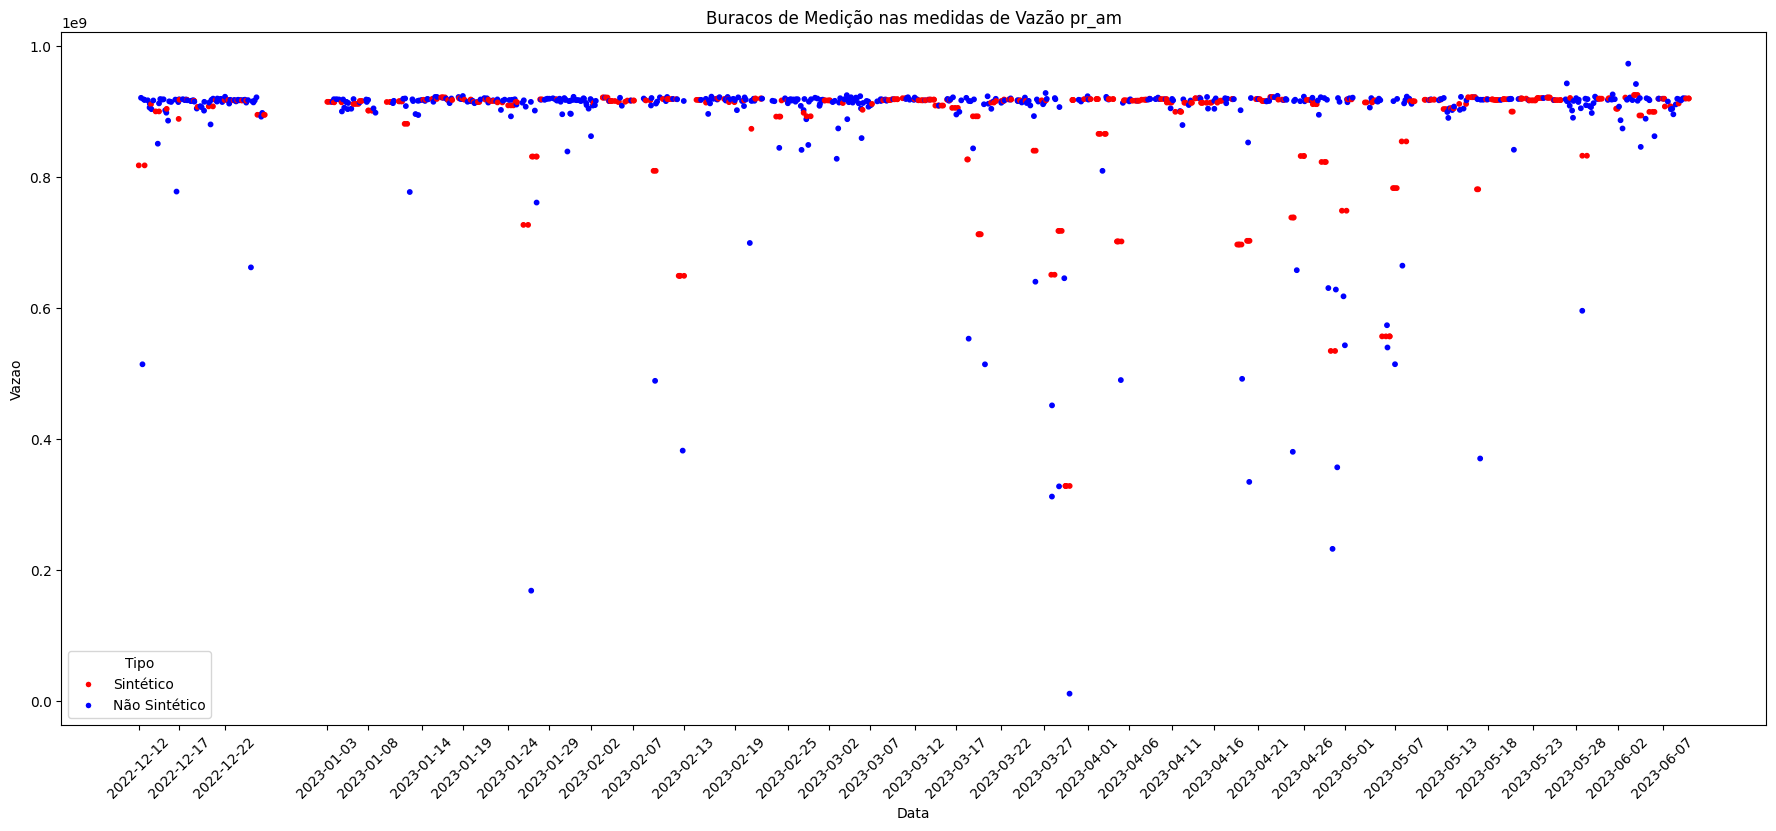

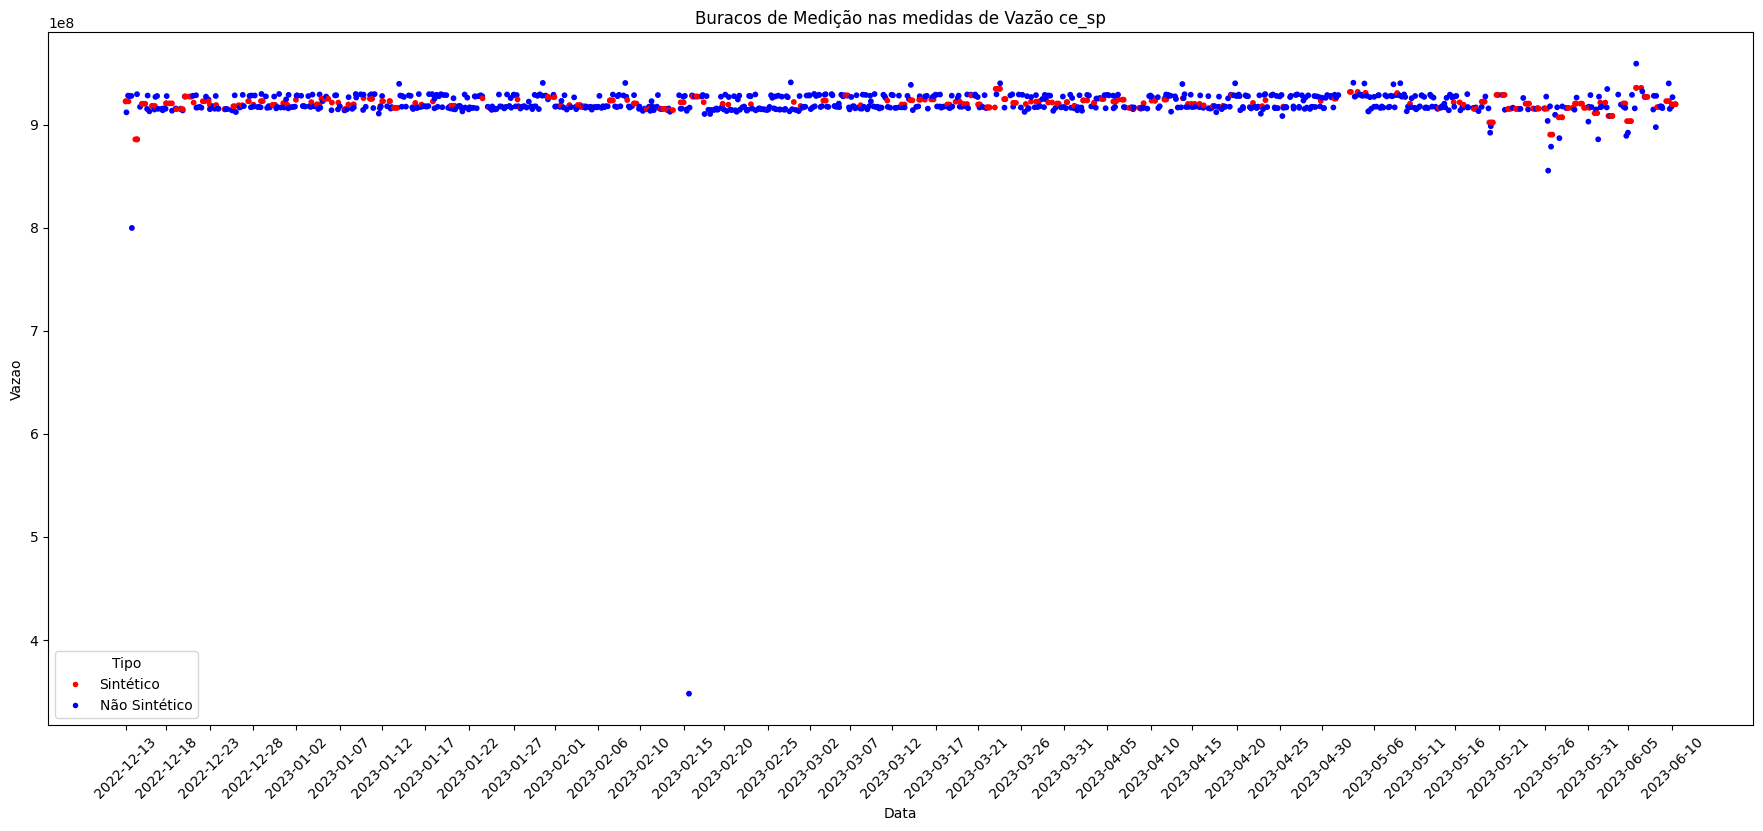

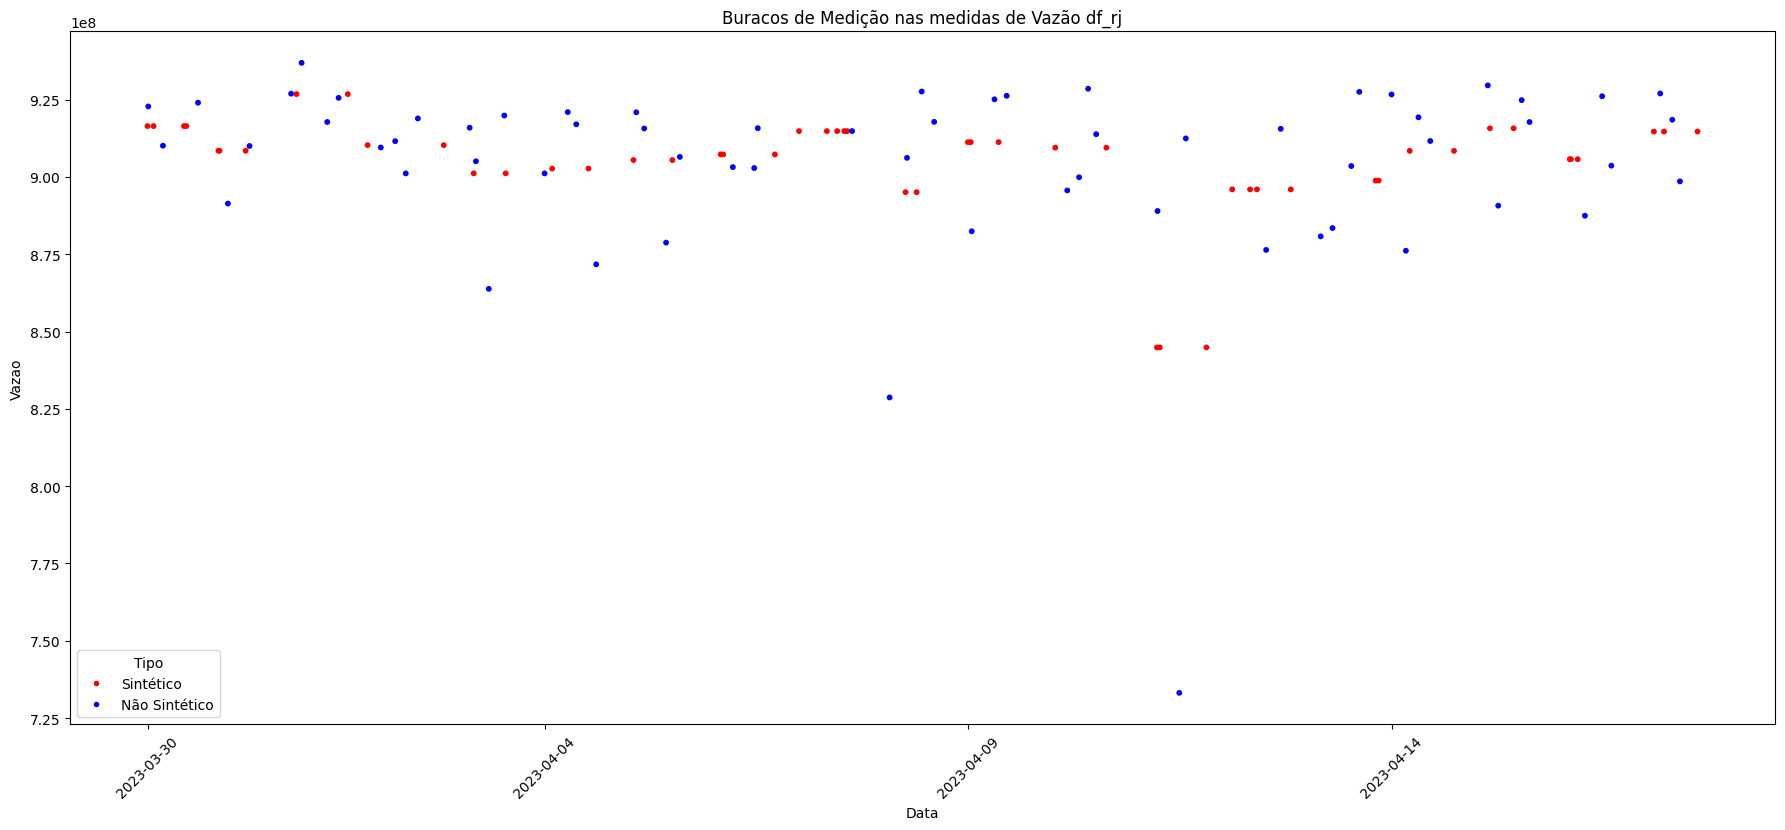

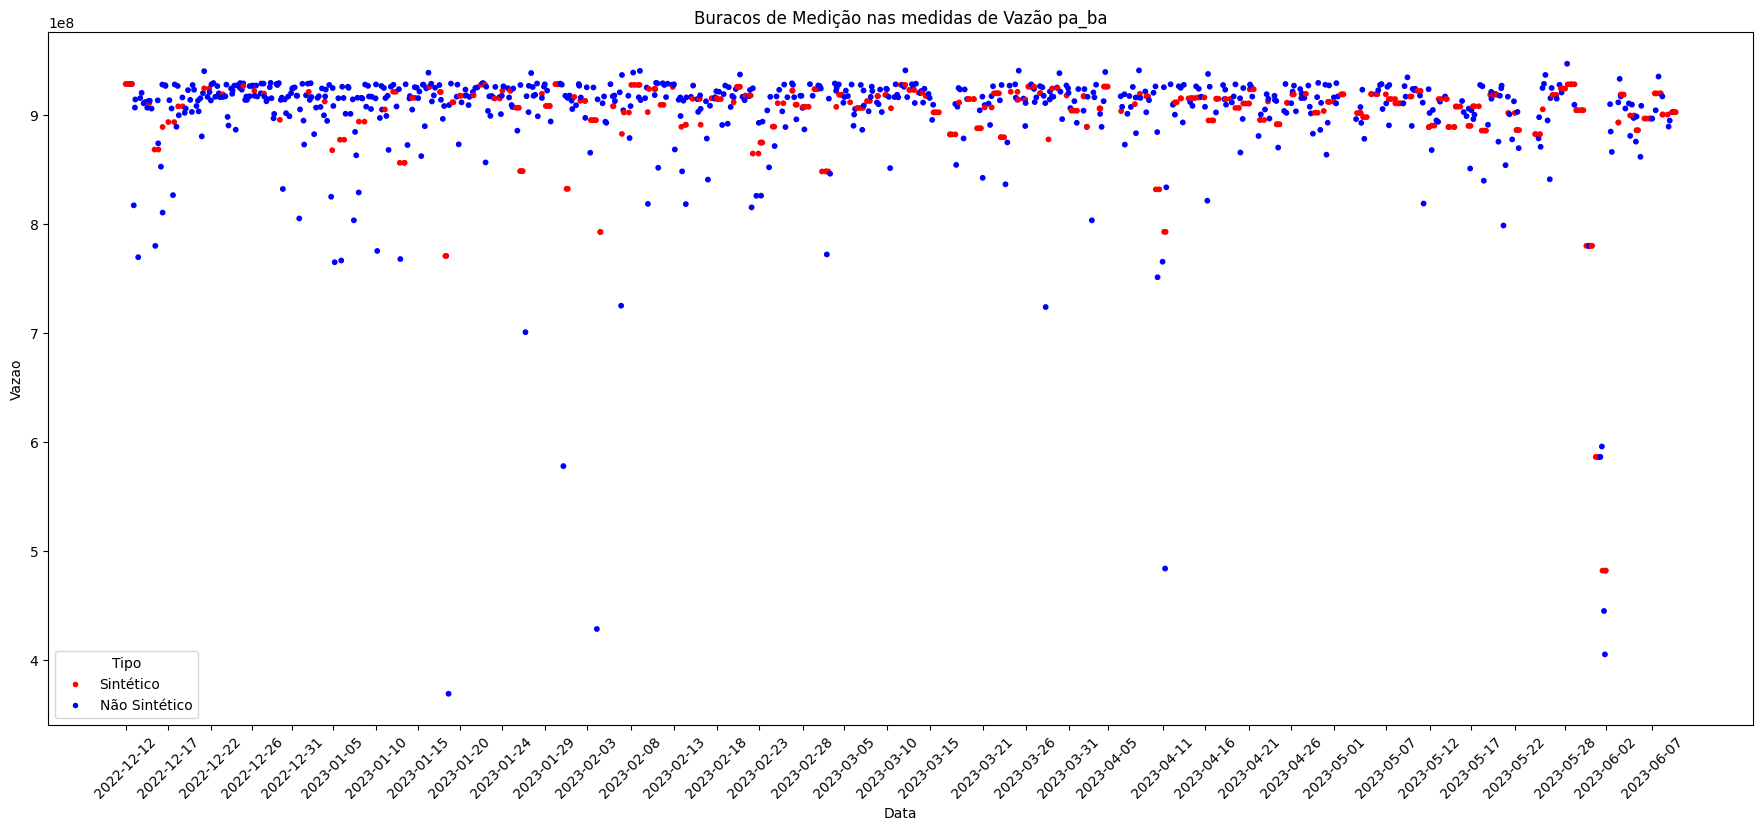

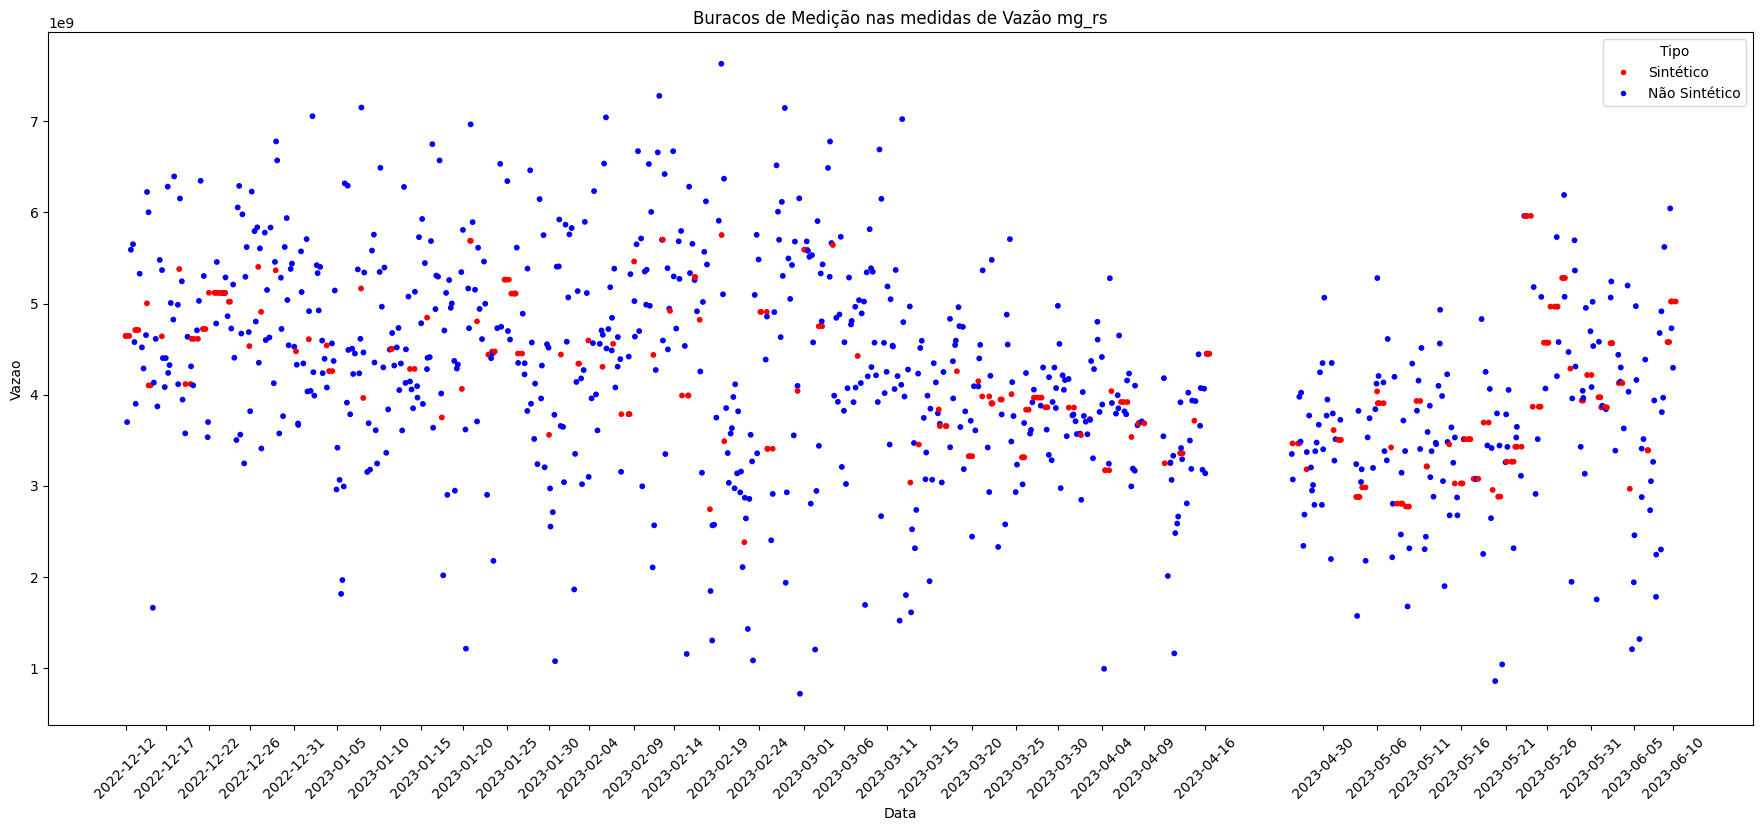

In [42]:
plot_scatter_vazao_tempo(pr_am_preenchido, 'pr_am_preenchido')
plot_scatter_vazao_tempo(ce_sp_preenchido, 'ce_sp_preenchido')
plot_scatter_vazao_tempo(df_rj_preenchido, 'df_rj_preenchido')
plot_scatter_vazao_tempo(pa_ba_preenchido, 'pa_ba_preenchido')
plot_scatter_vazao_tempo(mg_rs_preenchido, 'mg_rs_preenchido')

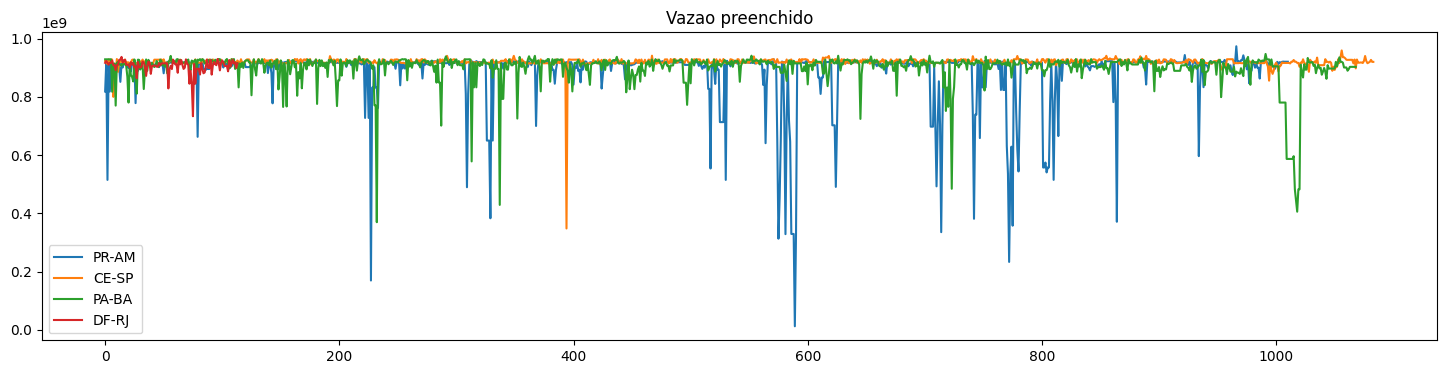

In [43]:
fig, axs = plt.subplots(figsize=(18, 4))

plt.plot(pr_am_preenchido['Vazao'], label = 'PR-AM')
plt.plot(ce_sp_preenchido['Vazao'], label = 'CE-SP')
plt.plot(pa_ba_preenchido['Vazao'], label = 'PA-BA')
plt.plot(df_rj_preenchido['Vazao'], label = 'DF-RJ')
#lt.plot(mg_rs_preenchido['Vazao'], label = 'MG-RS')
plt.title('Vazao preenchido')
plt.legend()

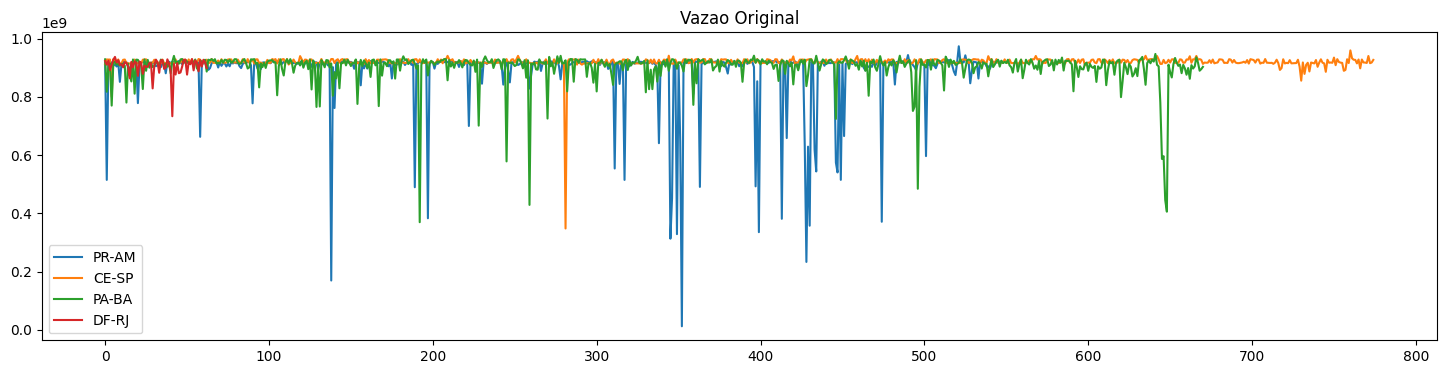

In [44]:
fig, axs = plt.subplots(figsize=(18, 4))

plt.plot(vazao_pr_am['Vazao'], label = 'PR-AM')
plt.plot(vazao_ce_sp['Vazao'], label = 'CE-SP')
plt.plot(vazao_pa_ba['Vazao'], label = 'PA-BA')
plt.plot(vazao_df_rj['Vazao'], label = 'DF-RJ')
#plt.plot(vazao_mg_rs['Vazao'])
plt.title('Vazao Original')
plt.legend()

# Vazao BBR 09-01-2023 a 07-07-2023 Intervalos média do turno

## Preenchimento dos turnos inicial

In [26]:
vazao_pa_ba_bbr_intervalos_sem_index = pd.read_csv('../datasets/vazao/jan-jul-2023/intervalos turnos/bbr/intervalos vazao bbr esmond data pa-ba 07-08-2023.csv')
vazao_pr_am_bbr_intervalos_sem_index = pd.read_csv('../datasets/vazao/jan-jul-2023/intervalos turnos/bbr/intervalos vazao bbr esmond data ce-sp 07-03-2023.csv')
vazao_ce_sp_bbr_intervalos_sem_index = pd.read_csv('../datasets/vazao/jan-jul-2023/intervalos turnos/bbr/intervalos vazao bbr esmond data ce-sp 07-03-2023.csv')
vazao_rr_rs_bbr_intervalos_sem_index = pd.read_csv('../datasets/vazao/jan-jul-2023/intervalos turnos/bbr/intervalos vazao bbr esmond data rr-rs 07-04-2023.csv')
vazao_mg_rs_bbr_intervalos_sem_index = pd.read_csv('../datasets/vazao/jan-jul-2023/intervalos turnos/bbr/intervalos vazao bbr esmond data mg-rs 07-03-2023.csv')

In [29]:
vazao_pr_am_bbr_intervalos

Intervalo        Vazao
Data                                       
4-1-2023   00:00:00 a 05:59:59         -1.0
 4-1-2023  06:00:00 a 11:59:59         -1.0
 4-1-2023  12:00:00 a 17:59:59  915198322.0
 4-1-2023  18:00:00 a 23:59:59  922826395.0
 5-1-2023  00:00:00 a 05:59:59  922909103.0
...                        ...          ...
 2-7-2023  18:00:00 a 23:59:59  926573626.0
 3-7-2023  00:00:00 a 05:59:59  920973375.5
 3-7-2023  06:00:00 a 11:59:59  914570319.0
 3-7-2023  12:00:00 a 17:59:59         -1.0
 3-7-2023  18:00:00 a 23:59:59         -1.0

[712 rows x 2 columns]

In [27]:
vazao_pr_am_bbr_intervalos = pd.read_csv('../datasets/vazao/jan-jul-2023/intervalos turnos/bbr/intervalos vazao bbr esmond data ce-sp 07-03-2023.csv', parse_dates=['Data'], dayfirst=True, index_col='Data')
vazao_ce_sp_bbr_intervalos = pd.read_csv('../datasets/vazao/jan-jul-2023/intervalos turnos/bbr/intervalos vazao bbr esmond data ce-sp 07-03-2023.csv', parse_dates=['Data'], dayfirst=True, index_col='Data')
vazao_rr_rs_bbr_intervalos = pd.read_csv('../datasets/vazao/jan-jul-2023/intervalos turnos/bbr/intervalos vazao bbr esmond data rr-rs 07-04-2023.csv', parse_dates=['Data'], dayfirst=True, index_col='Data')
vazao_pa_ba_bbr_intervalos = pd.read_csv('../datasets/vazao/jan-jul-2023/intervalos turnos/bbr/intervalos vazao bbr esmond data pa-ba 07-08-2023.csv', parse_dates=['Data'], dayfirst=True, index_col='Data')
vazao_mg_rs_bbr_intervalos = pd.read_csv('../datasets/vazao/jan-jul-2023/intervalos turnos/bbr/intervalos vazao bbr esmond data mg-rs 07-03-2023.csv', parse_dates=['Data'], dayfirst=True, index_col='Data')

In [20]:
def calcular_media_por_grupo(df, data, vazao):
    resultado = []
    grupo_atual = None
    soma = 0
    contador = 0

    for index, row in df.iterrows():
        if grupo_atual is None:
            grupo_atual = row[data]

        if row[data] == grupo_atual:
            if row[vazao] != -1:
                soma += row[vazao]
                contador += 1
        else:
            if contador > 0:
                media = soma / contador
                resultado.append({data: grupo_atual, vazao: media})

            grupo_atual = row[data]
            soma = 0
            contador = 0

            if row[vazao] != -1:
                soma += row[vazao]
                contador += 1

    if contador > 0:
        media = soma / contador
        resultado.append({data: grupo_atual, vazao: media})

    return pd.DataFrame(resultado)

In [23]:
# Exemplo de uso
vazao_pa_ba_bbr_original = calcular_media_por_grupo(vazao_pa_ba_bbr_intervalos_sem_index, 'Data', 'Vazao').set_index('Data')
vazao_pr_am_bbr_original = calcular_media_por_grupo(vazao_pr_am_bbr_intervalos_sem_index, 'Data', 'Vazao').set_index('Data')
vazao_ce_sp_bbr_original = calcular_media_por_grupo(vazao_ce_sp_bbr_intervalos_sem_index, 'Data', 'Vazao').set_index('Data')
vazao_rr_rs_bbr_original = calcular_media_por_grupo(vazao_rr_rs_bbr_intervalos_sem_index, 'Data', 'Vazao').set_index('Data')
vazao_mg_rs_bbr_original = calcular_media_por_grupo(vazao_mg_rs_bbr_intervalos_sem_index, 'Data', 'Vazao').set_index('Data')

In [49]:
# Intervalos preenchido com um valor entre a média e o desvio padrao do dia
vazao_pr_am_bbr_intervalos_preenchido_std = substituicao_intervalos_mean_std(vazao_pr_am_bbr_intervalos)
vazao_ce_sp_bbr_intervalos_preenchido_std = substituicao_intervalos_mean_std(vazao_ce_sp_bbr_intervalos)
vazao_rr_rs_bbr_intervalos_preenchido_std = substituicao_intervalos_mean_std(vazao_rr_rs_bbr_intervalos)
vazao_pa_ba_bbr_intervalos_preenchido_std = substituicao_intervalos_mean_std(vazao_pa_ba_bbr_intervalos)
vazao_mg_rs_bbr_intervalos_preenchido_std = substituicao_intervalos_mean_std(vazao_mg_rs_bbr_intervalos)

## Dados originais

NameError: name 'vazao_pr_am_bbr_intervalos_preenchido_daymean' is not defined

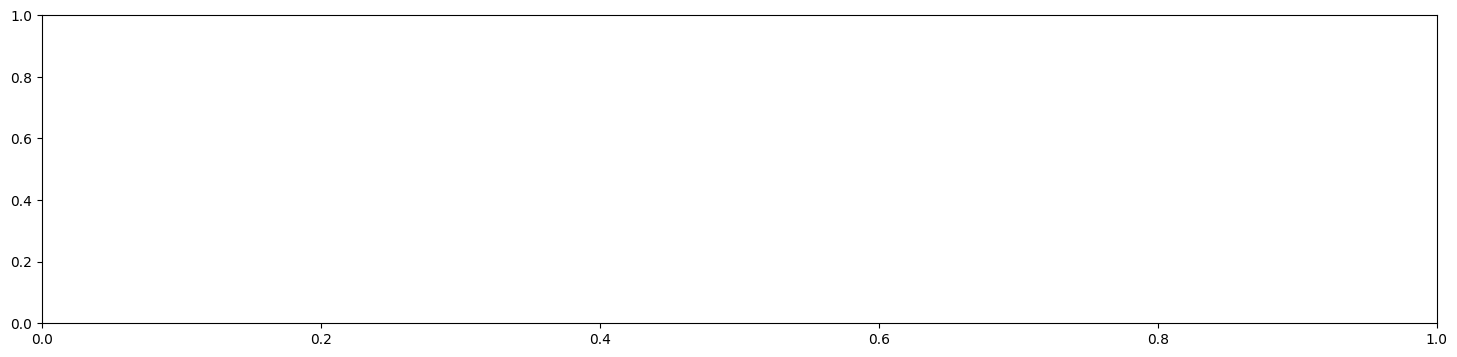

In [51]:
# Comparação pr-am
fig, axs = plt.subplots(figsize=(18, 4))

plt.plot(vazao_pr_am_bbr_intervalos_preenchido_daymean.index, vazao_pr_am_bbr_intervalos_preenchido_daymean['Vazao'],label = 'média dia')
plt.plot(vazao_pr_am_bbr_intervalos_preenchido_std.index, vazao_pr_am_bbr_intervalos_preenchido_std['Vazao'],label = 'desvio padrão')

plt.xticks(vazao_pr_am_bbr_intervalos_preenchido_daymean.index[::400])
plt.title('Vazao preenchido pr-am')
plt.legend()

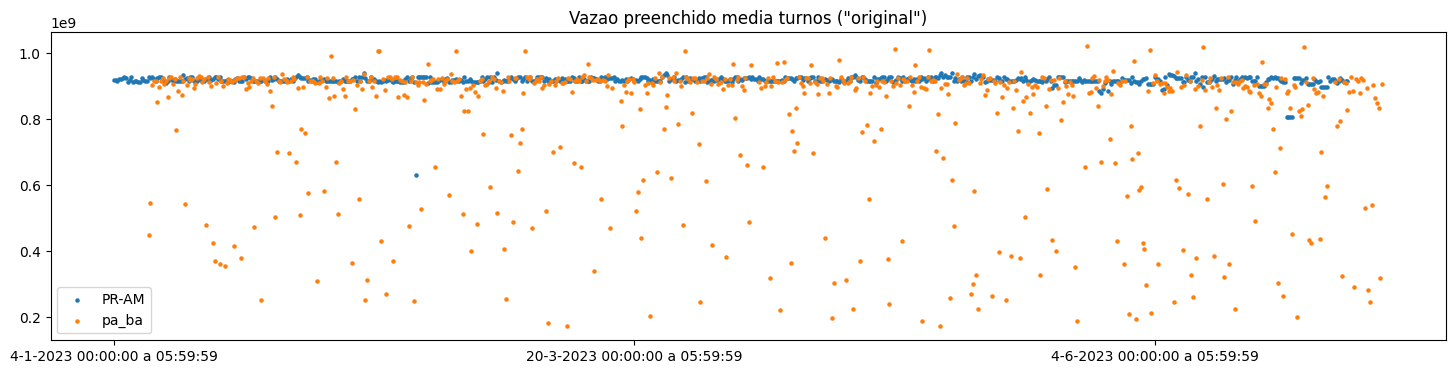

In [ ]:
fig, axs = plt.subplots(figsize=(18, 4))

# plt.scatter(vazao_ce_sp_bbr_intervalos_preenchido.index, vazao_ce_sp_bbr_intervalos_preenchido['Vazao'],s=5,label = 'ce-sp', marker='o')
#plt.scatter(vazao_mg_rs_bbr_intervalos_preenchido.index, vazao_mg_rs_bbr_intervalos_preenchido['Vazao'],s=5,label = 'mg_rs', marker='o')
plt.scatter(vazao_pr_am_bbr_intervalos_preenchido_daymean.index, vazao_pr_am_bbr_intervalos_preenchido_daymean['Vazao'],s=5,label = 'PR-AM', marker='o')
# plt.scatter(vazao_rr_rs_bbr_intervalos_preenchido.index, vazao_rr_rs_bbr_intervalos_preenchido['Vazao'],s=5,label = 'rr_rs', marker='o')
plt.scatter(vazao_pa_ba_bbr_intervalos_preenchido_std.index, vazao_pa_ba_bbr_intervalos_preenchido_std['Vazao'],s=5,label = 'pa_ba', marker='o')

plt.xticks(vazao_pr_am_bbr_intervalos_preenchido_daymean.index[::300])
plt.title('Vazao preenchido media turnos ("original")')
plt.legend()

NameError: name 'vazao_pr_am_bbr_intervalos_preenchido' is not defined

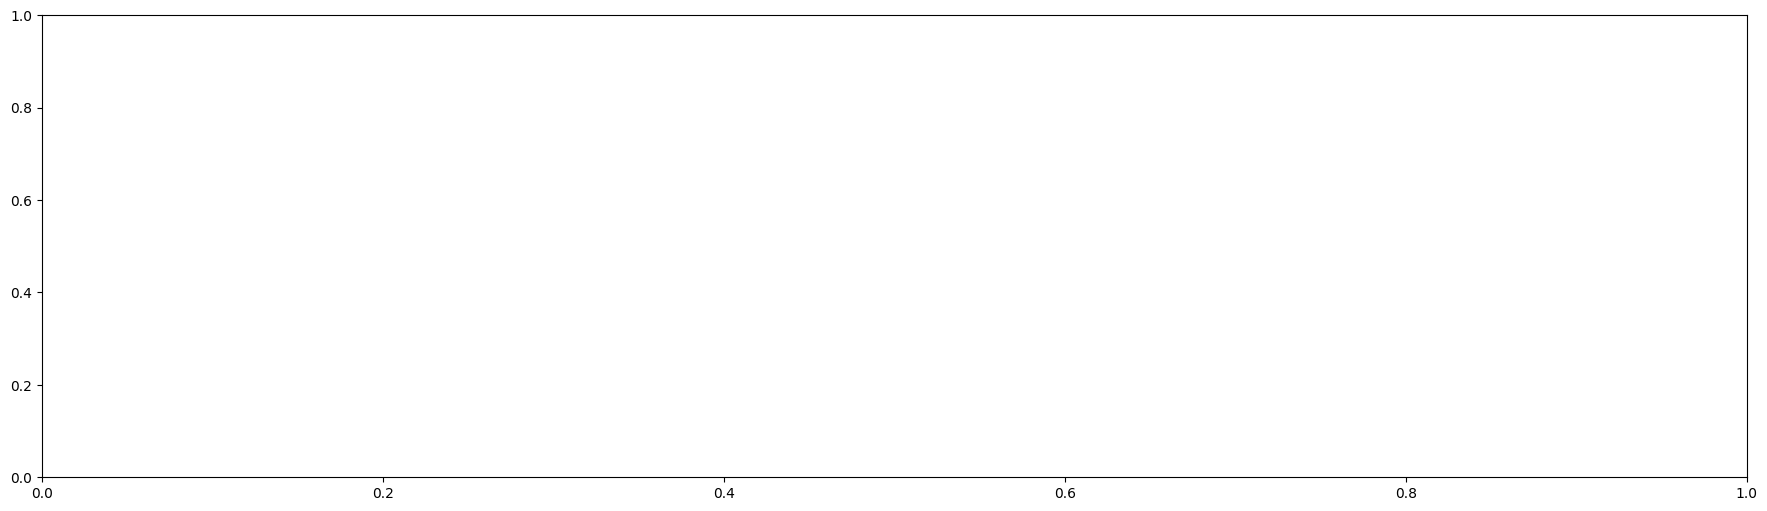

In [ ]:
fig, axs = plt.subplots(figsize=(22, 6))

# plt.scatter(vazao_ce_sp_bbr_intervalos_preenchido.index, vazao_ce_sp_bbr_intervalos_preenchido['Vazao'],s=7,label = 'ce-sp', marker='o')
# plt.scatter(vazao_mg_rs_bbr_intervalos_preenchido.index, vazao_mg_rs_bbr_intervalos_preenchido['Vazao'],s=7,label = 'mg_rs', marker='o')
plt.scatter(vazao_pr_am_bbr_intervalos_preenchido.index, vazao_pr_am_bbr_intervalos_preenchido['Vazao'],s=7,label = 'PR-AM', marker='o')
# plt.scatter(vazao_rr_rs_bbr_intervalos_preenchido.index, vazao_rr_rs_bbr_intervalos_preenchido['Vazao'],s=7,label = 'rr_rs', marker='o')
plt.scatter(vazao_pa_ba_bbr_intervalos_preenchido.index, vazao_pa_ba_bbr_intervalos_preenchido['Vazao'],s=7,label = 'pa_ba', marker='o')

plt.title('Vazao preenchido media turnos ("original")')
plt.legend()

## Valores inputados

In [ ]:
pa_ba_interpolacao_linear = pd.read_csv('../datasets/vazao/10-06-2023/preenchido/bbr/interpolacao/linear/preenchido bbr esmond data pa-ba 06-10-2023.csv', index_col='Data')
pr_am_interpolacao_linear = pd.read_csv('../datasets/vazao/10-06-2023/preenchido/bbr/interpolacao/linear/preenchido bbr esmond data pr-am 06-10-2023.csv', index_col='Data')

pr_am_knn = pd.read_csv('../datasets/vazao/10-06-2023/preenchido/bbr/knn/preenchido bbr esmond data pr-am 06-10-2023.csv', index_col='Data')
pa_ba_knn = pd.read_csv('../datasets/vazao/10-06-2023/preenchido/bbr/knn/preenchido bbr esmond data pa-ba 06-10-2023.csv', index_col='Data')

# Muiots valores nulos
# pa_ba_media_movel = pd.read_csv('../datasets/vazao/10-06-2023/preenchido/bbr/media-movel/preenchido bbr esmond data pa-ba 06-10-2023.csv')
# pr_am_media_movel = pd.read_csv('../datasets/vazao/10-06-2023/preenchido/bbr/media-movel/preenchido bbr esmond data pr-am 06-10-2023.csv')

# pa_ba_mediana_movel = pd.read_csv('../datasets/vazao/10-06-2023/preenchido/bbr/mediana-movel/preenchido bbr esmond data pa-ba 06-10-2023.csv')
# pr_am_mediana_movel = pd.read_csv('../datasets/vazao/10-06-2023/preenchido/bbr/mediana-movel/preenchido bbr esmond data pr-am 06-10-2023.csv')


In [ ]:
pa_ba_interpolacao_linear_plot = adequacao_serie_plot(pa_ba_interpolacao_linear)
pr_am_interpolacao_linear_plot = adequacao_serie_plot(pr_am_interpolacao_linear)

pr_am_knn_plot = adequacao_serie_plot(pr_am_knn)
pa_ba_knn_plot = adequacao_serie_plot(pa_ba_knn)

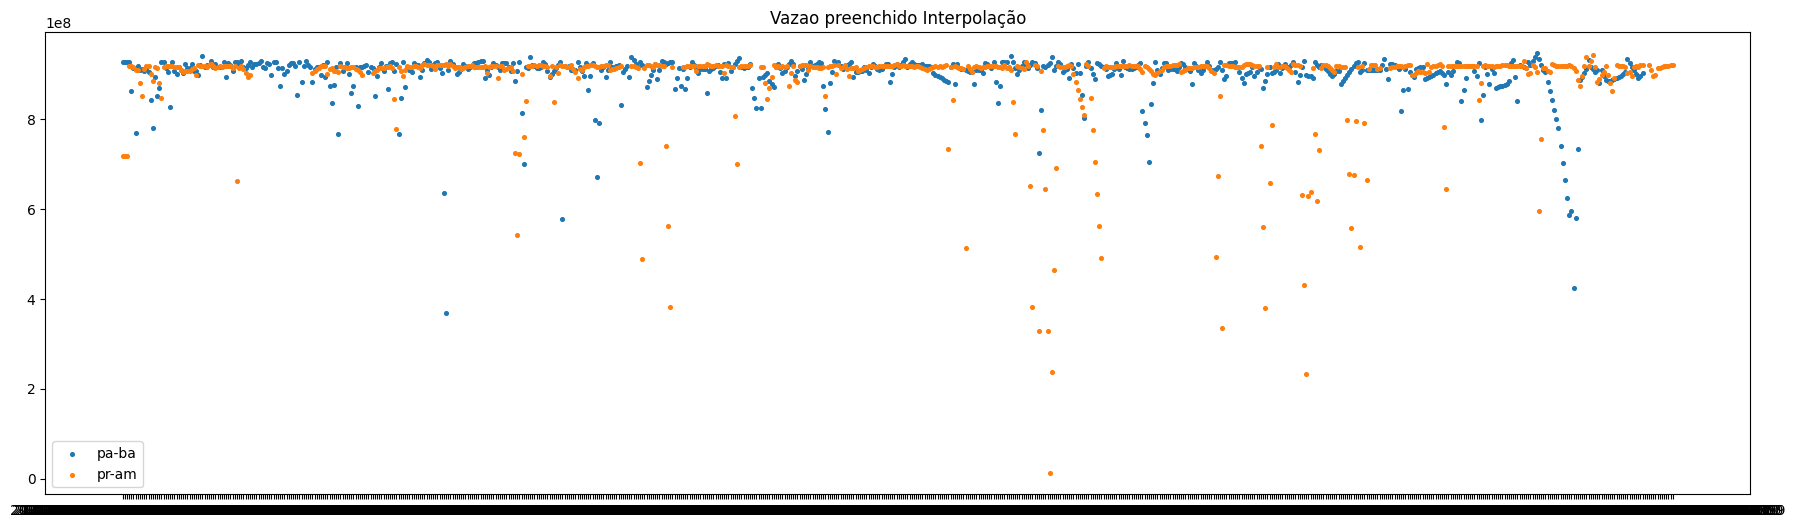

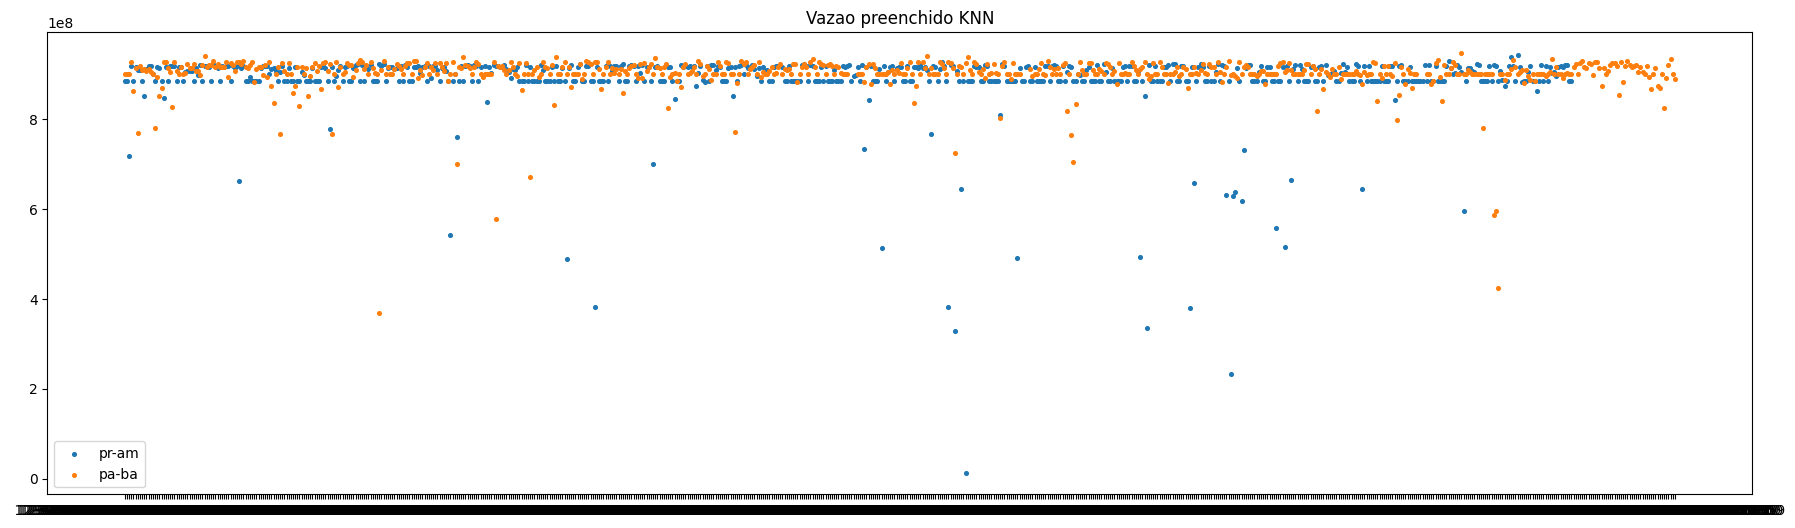

In [ ]:
fig, axs = plt.subplots(figsize=(22, 6))

plt.scatter(pa_ba_interpolacao_linear.index, pa_ba_interpolacao_linear['Vazao'],s=7,label = 'pa-ba', marker='o')
plt.scatter(pr_am_interpolacao_linear.index, pr_am_interpolacao_linear['Vazao'],s=7,label = 'pr-am', marker='o')

plt.title('Vazao preenchido Interpolação')
plt.legend()

fig, axs = plt.subplots(figsize=(22, 6))

plt.scatter(pr_am_knn.index, pr_am_knn['Vazao'],s=7,label = 'pr-am', marker='o')
plt.scatter(pa_ba_knn.index, pa_ba_knn['Vazao'],s=7,label = 'pa-ba', marker='o')

plt.title('Vazao preenchido KNN')
plt.legend()

## Decomposição

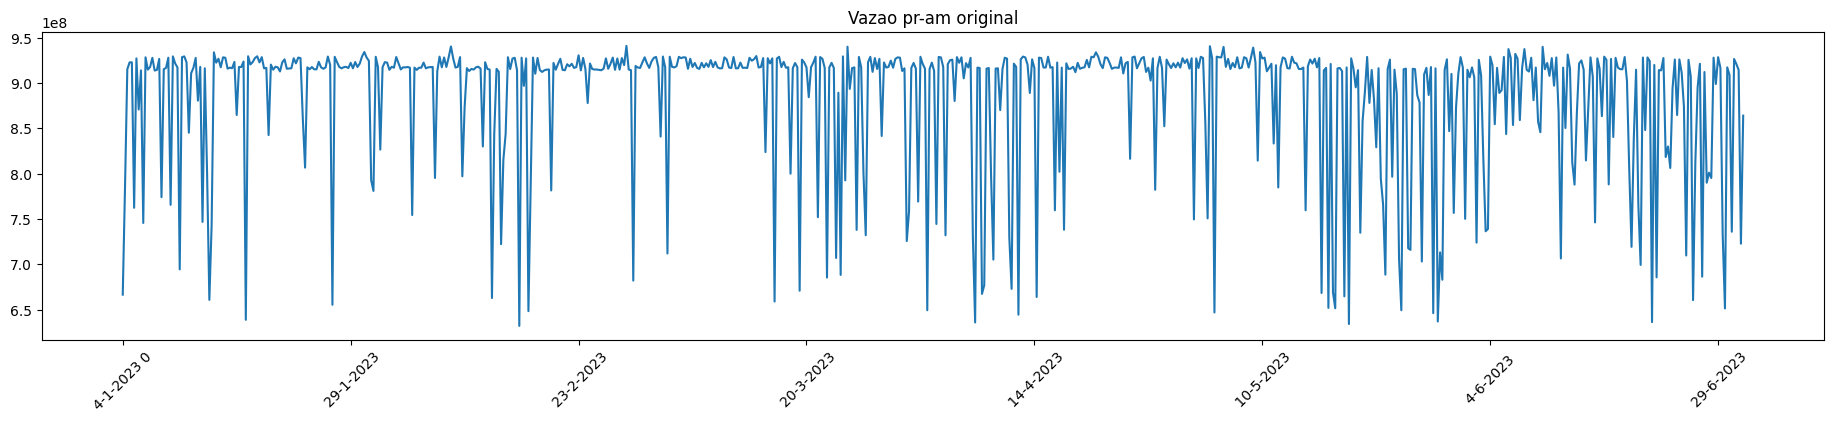

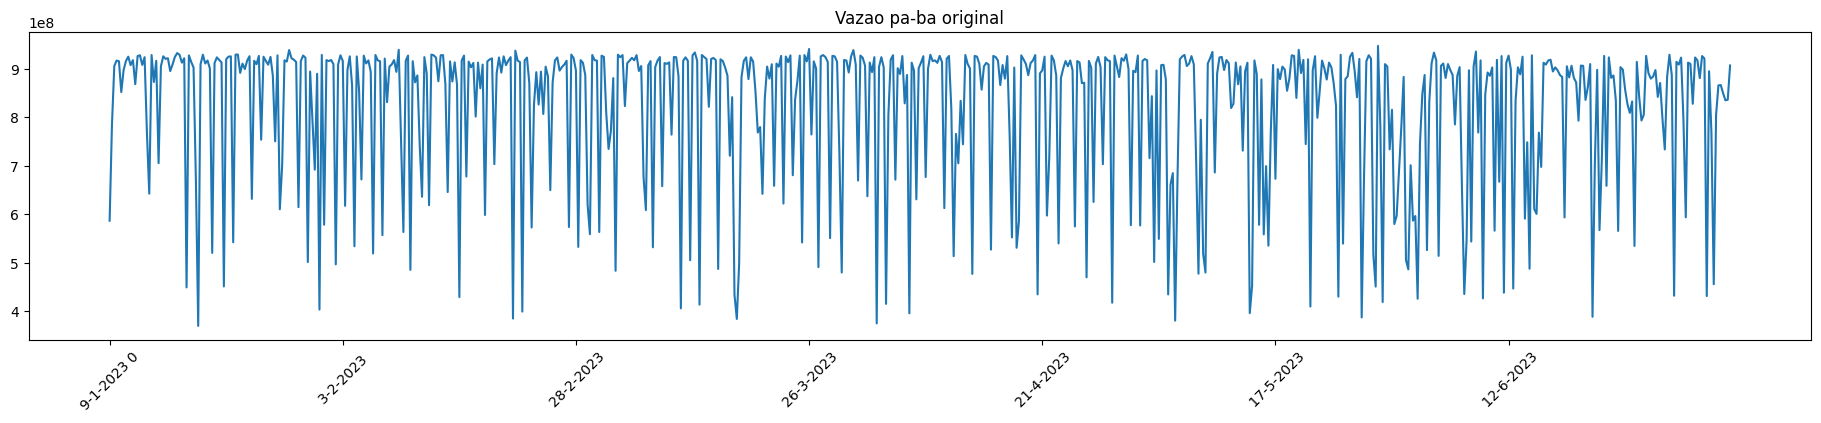

In [ ]:
# plot_serie_turnos(vazao_ce_sp_bbr_intervalos_preenchido, 'Vazao ce-sp')
plot_serie_turnos(vazao_pr_am_bbr_intervalos_preenchido, 'Vazao pr-am original')
# plot_serie_turnos(vazao_mg_rs_bbr_intervalos_preenchido, 'Vazao mg-rs')
plot_serie_turnos(vazao_pa_ba_bbr_intervalos_preenchido, 'Vazao pa-ba original')
# plot_serie_turnos(vazao_rr_rs_bbr_intervalos_preenchido, 'Vazao rr-rs')

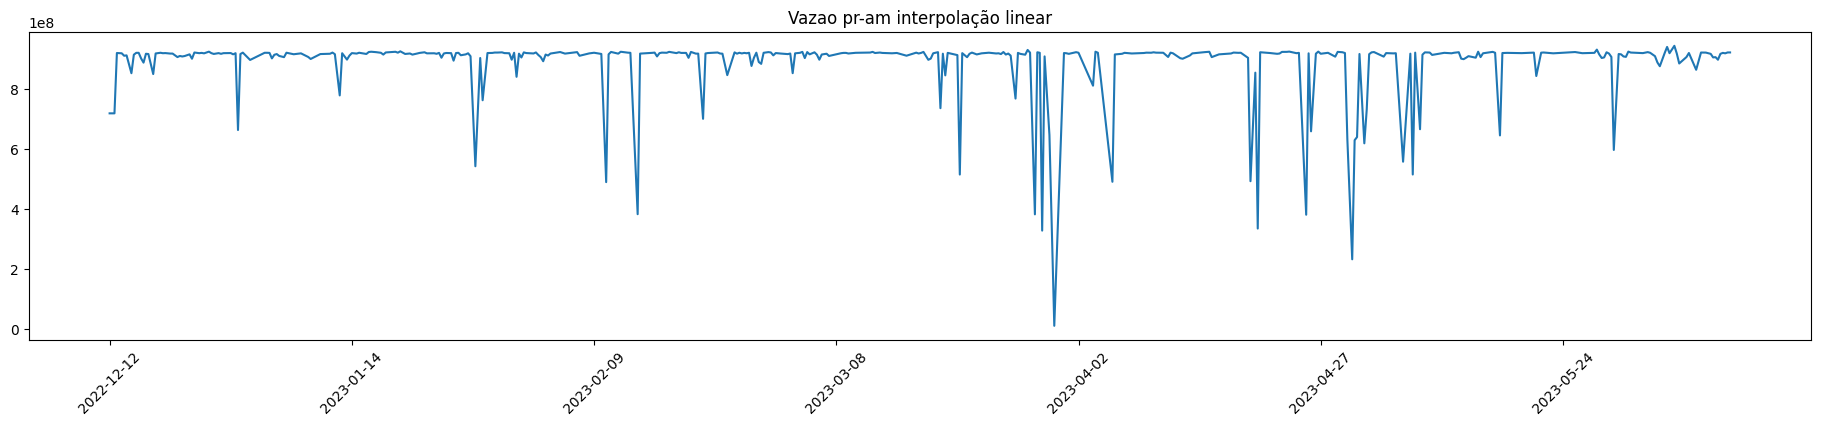

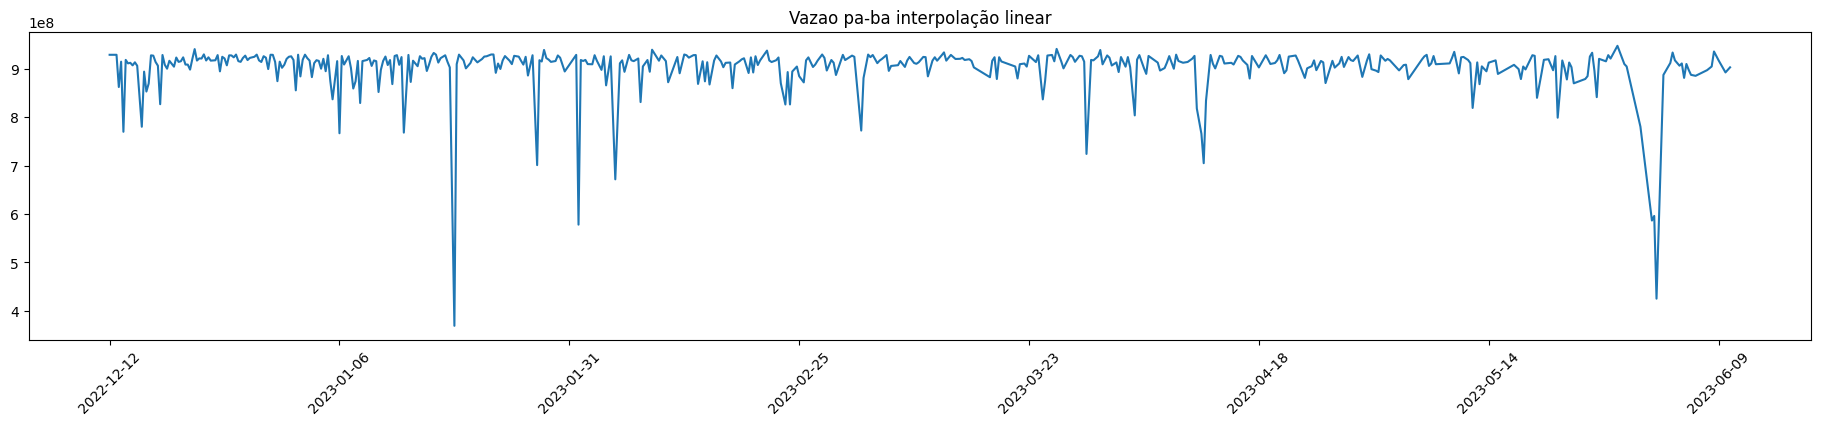

In [ ]:
plot_serie_turnos(pr_am_interpolacao_linear_plot, 'Vazao pr-am interpolação linear')
plot_serie_turnos(pa_ba_interpolacao_linear_plot, 'Vazao pa-ba interpolação linear')

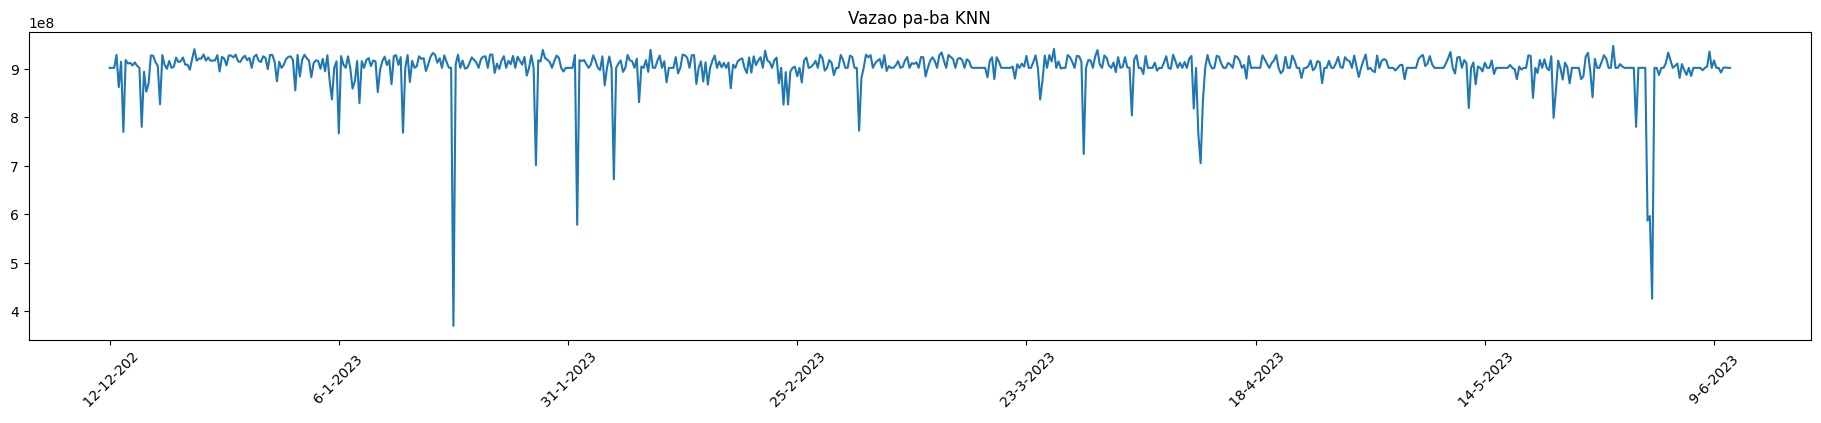

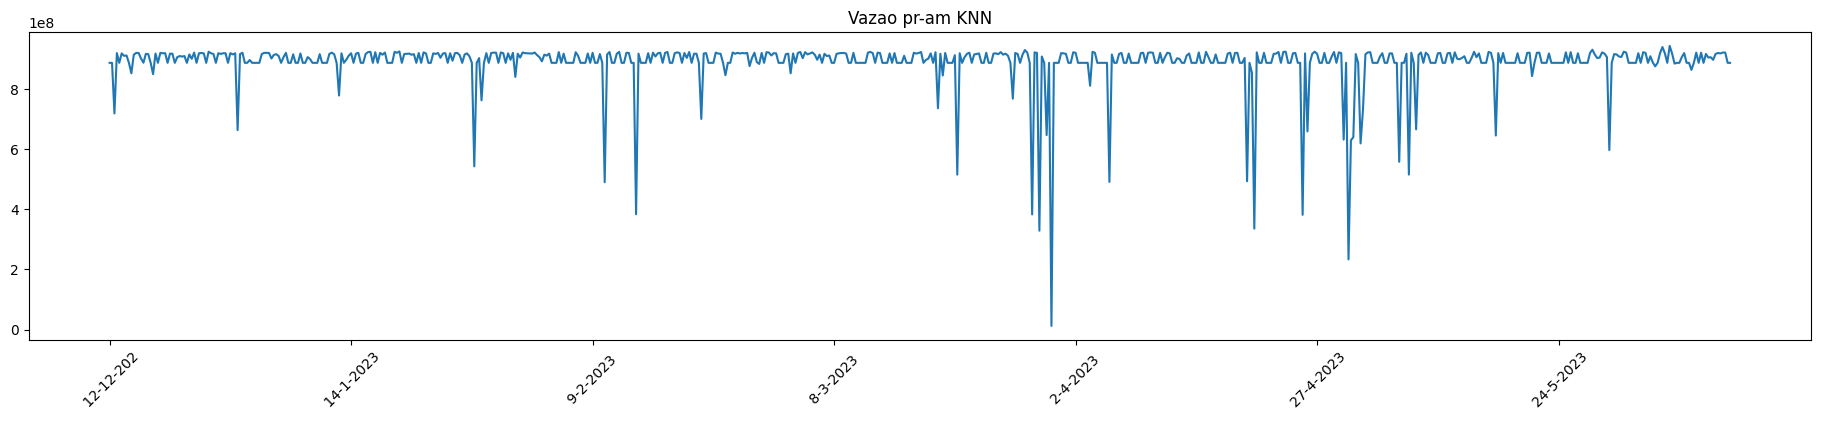

In [ ]:
plot_serie_turnos(pa_ba_knn_plot, 'Vazao pa-ba KNN')
plot_serie_turnos(pr_am_knn_plot, 'Vazao pr-am KNN')

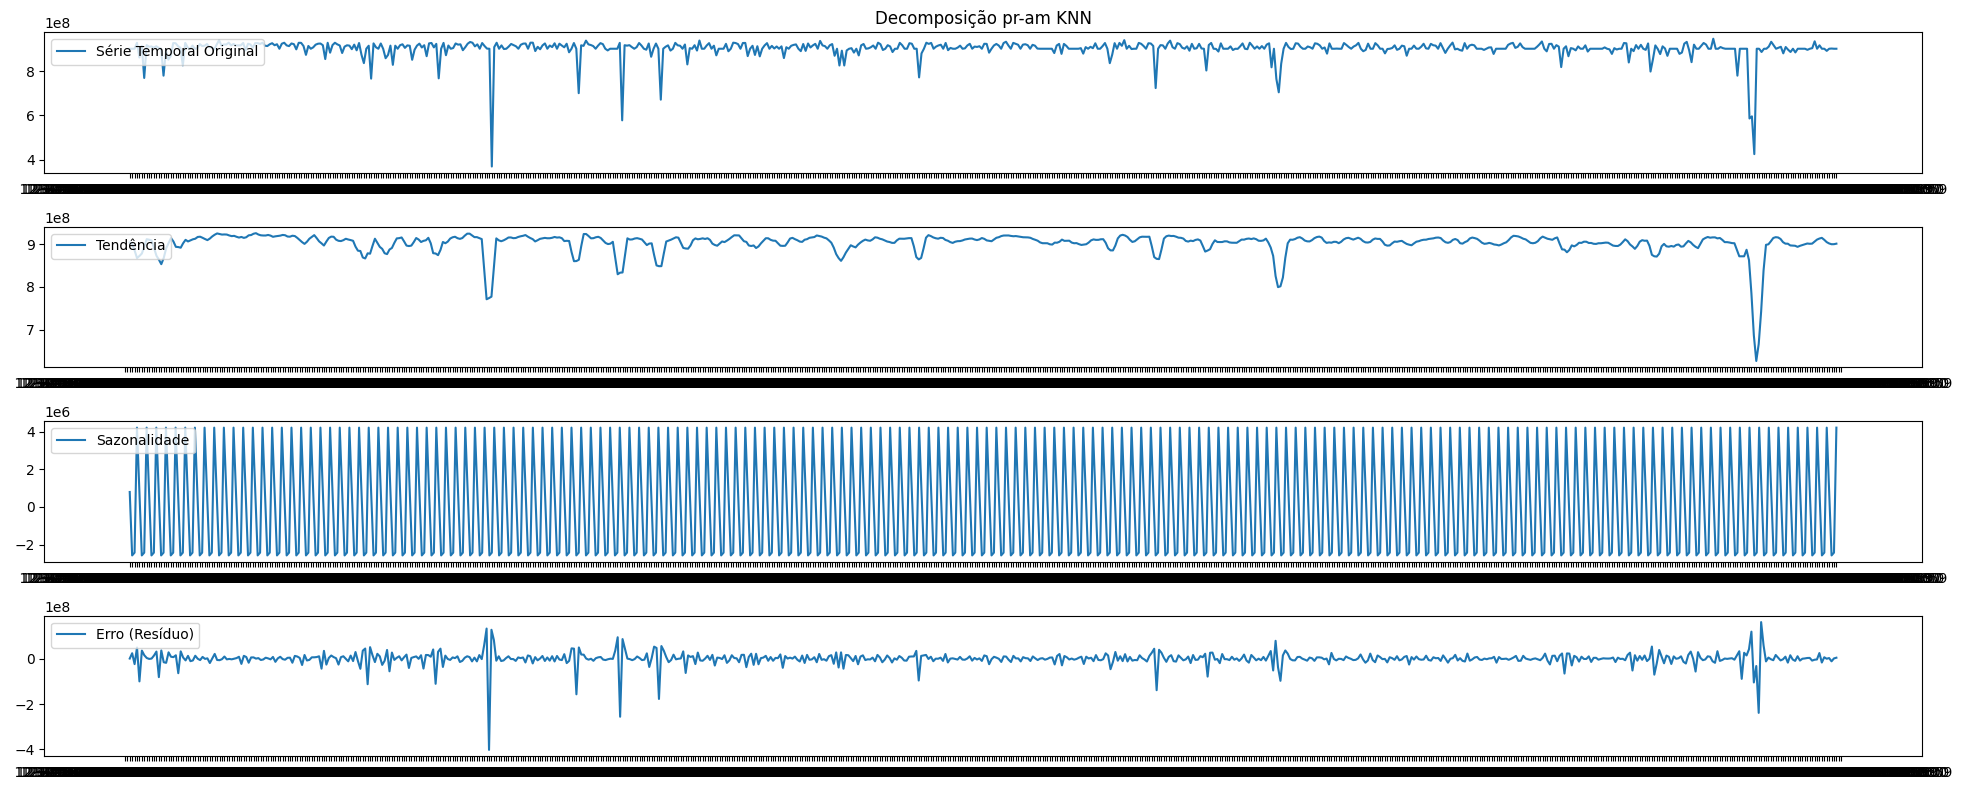

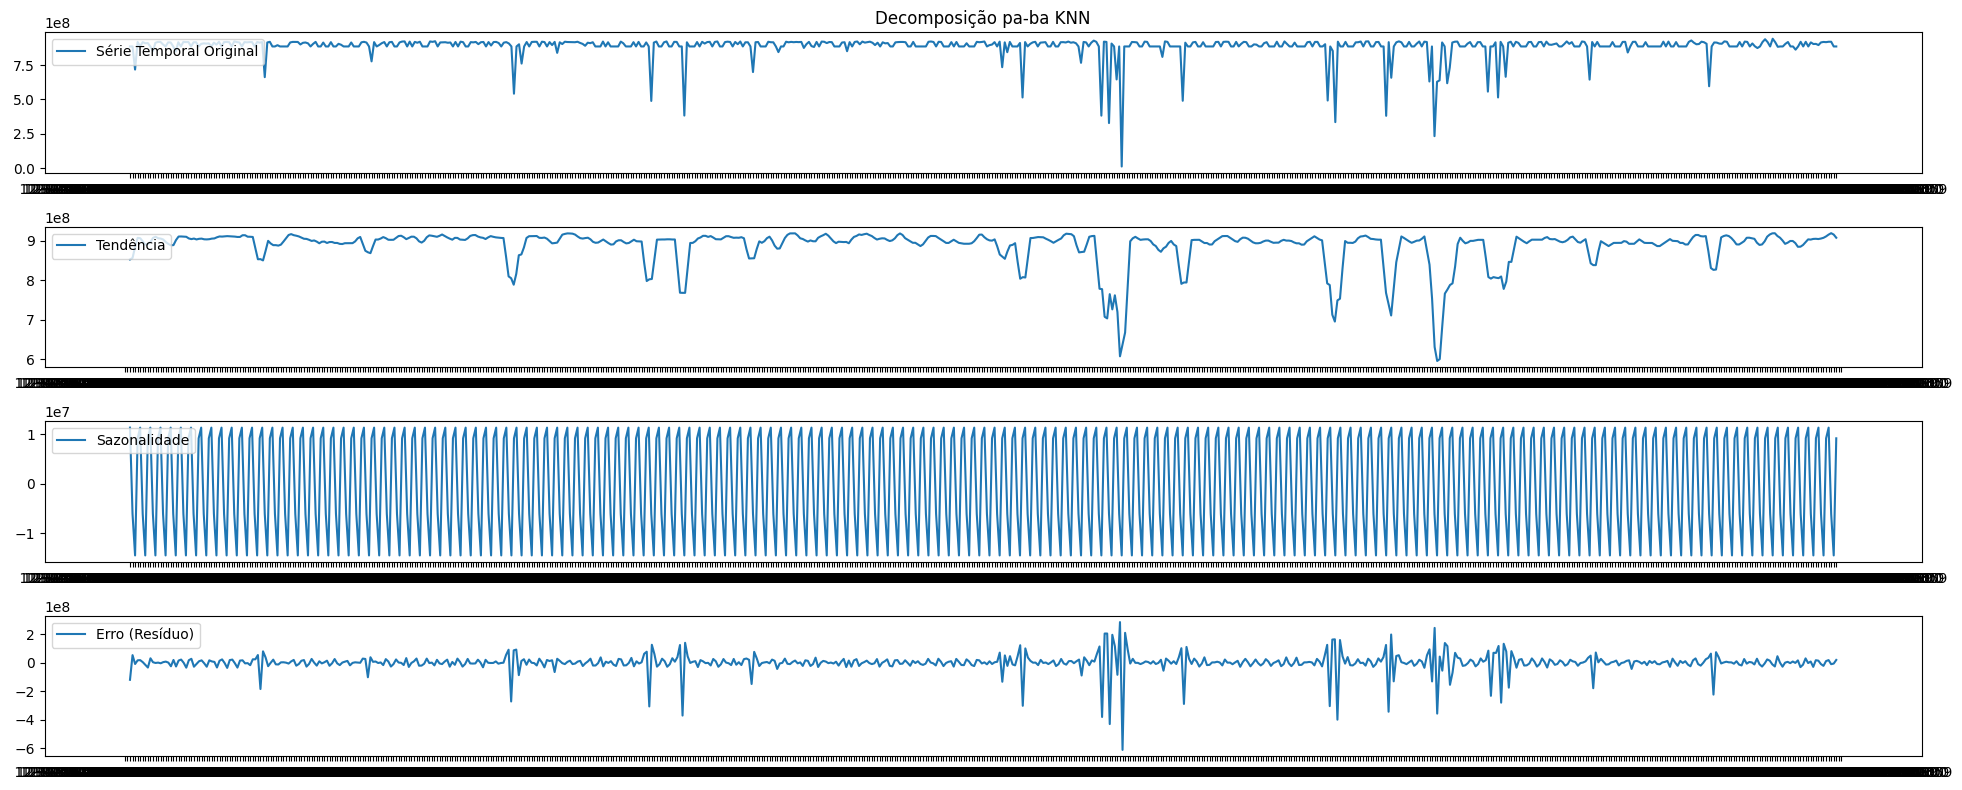

In [ ]:
plot_decomposicao_serie_temporal(pa_ba_knn_plot, 'Vazao', 4, 'Decomposição pr-am KNN') #série, coluna, periodo
plot_decomposicao_serie_temporal(pr_am_knn_plot, 'Vazao', 4, 'Decomposição pa-ba KNN') #série, coluna, periodo

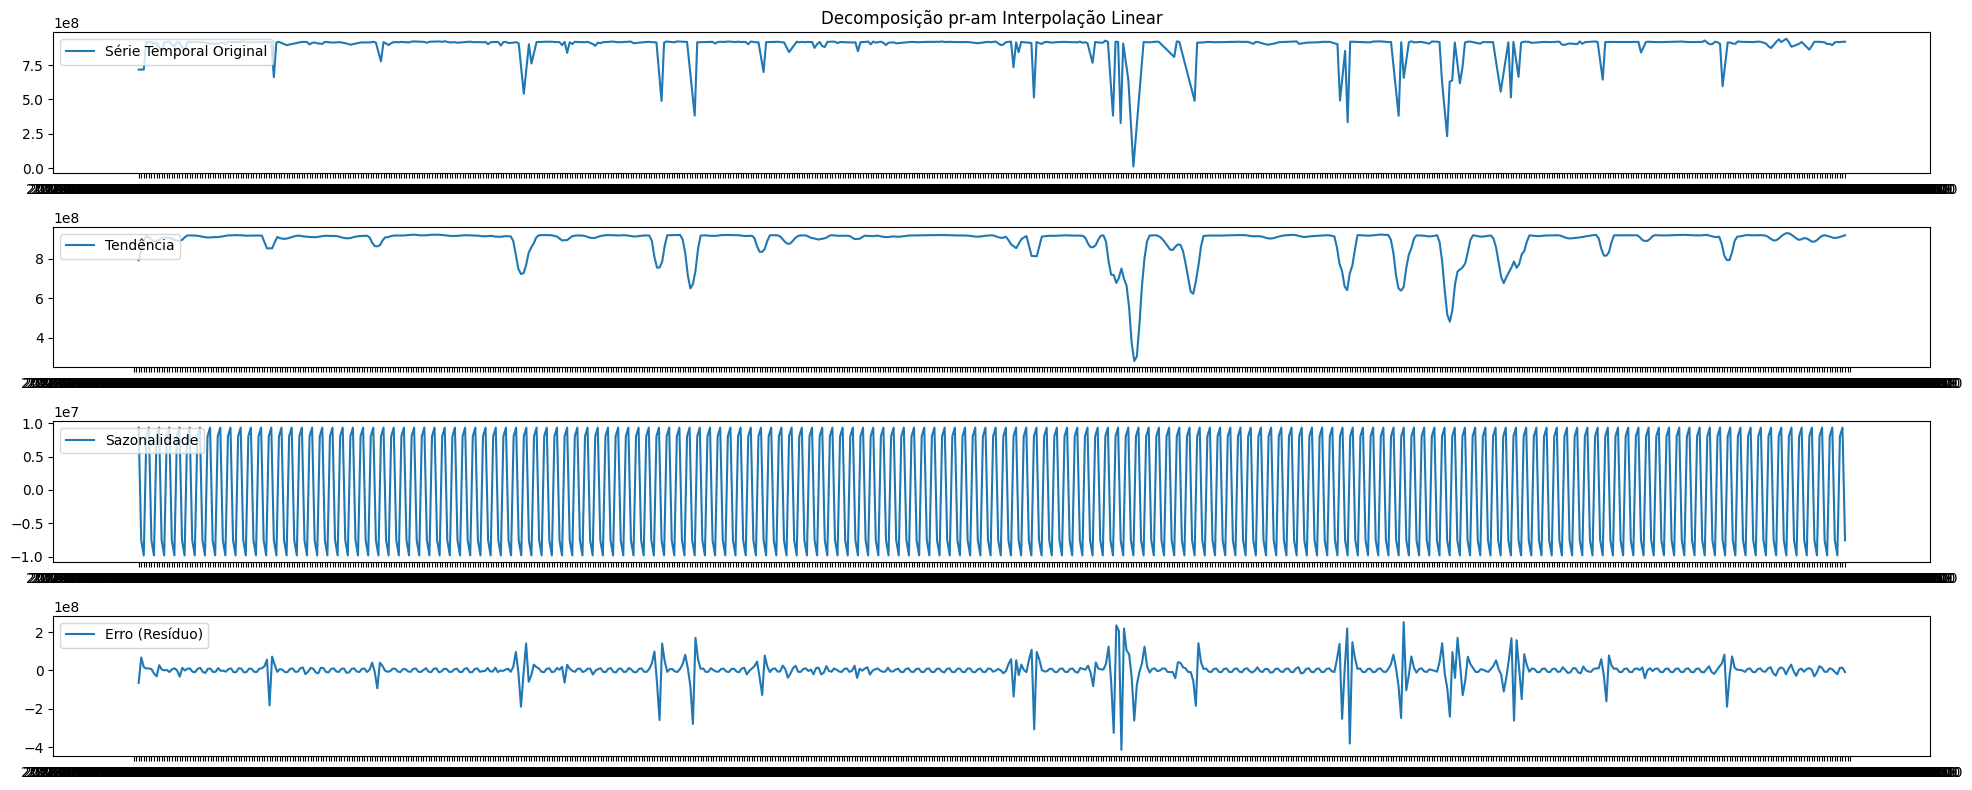

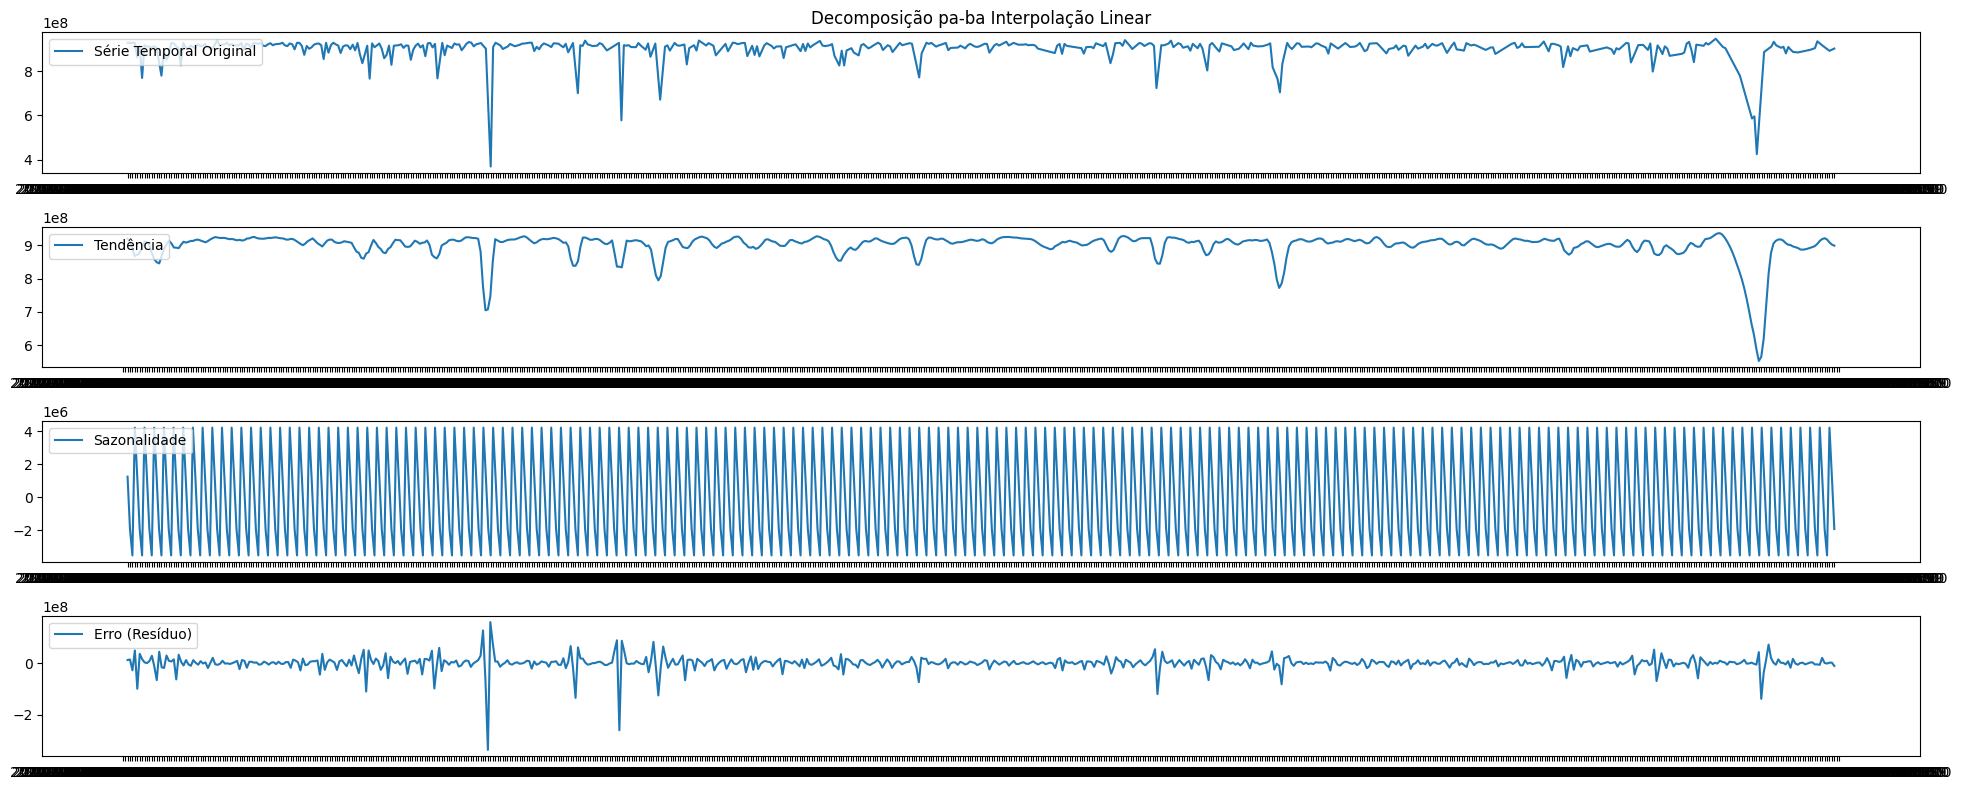

In [ ]:
plot_decomposicao_serie_temporal(pr_am_interpolacao_linear_plot, 'Vazao', 4, 'Decomposição pr-am Interpolação Linear') #série, coluna, periodo
plot_decomposicao_serie_temporal(pa_ba_interpolacao_linear_plot, 'Vazao', 4, 'Decomposição pa-ba Interpolação Linear') #série, coluna, periodo

In [ ]:
plot_decomposicao_serie_temporal(vazao_pr_am_bbr_intervalos_preenchido_std, 'Vazao', 4, 'Decomposição pr-am std') #série, coluna, periodo
plot_decomposicao_serie_temporal(vazao_pr_am_bbr_intervalos_preenchido, 'Vazao', 4, 'Decomposição pr-am aleatorio') #série, coluna, periodo

KeyboardInterrupt: 

## Predição Valores Originais x Inputados

In [52]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from .modelo_de_predição_rnp.GRU_LSTM import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

2023-10-18 13:29:20.451623: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-18 13:29:20.453138: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 13:29:20.515075: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 13:29:20.517667: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 13:29:21.213595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### Scripts

In [53]:
def window_set(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [54]:
def criar_modelo():
    model_LSTM = Sequential()
    model_LSTM.add(InputLayer((3, 1)))
    model_LSTM.add(LSTM(64))
    model_LSTM.add(Dense(8, 'relu'))
    model_LSTM.add(Dense(1, 'linear'))
    
    return model_LSTM

### View

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_LSTM = criar_modelo()

# Defina o callback ModelCheckpoint como antes
cp_ce_sp = ModelCheckpoint('modelos/modelos_LSTM/treinado_ce_sp', save_best_only=True)

# Defina o callback EarlyStopping para monitorar a perda (loss) no conjunto de validação
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_LSTM.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00001), metrics=[RootMeanSquaredError()])

# Adicione o callback EarlyStopping à lista de callbacks
history = model_LSTM.fit(X_train_ce_sp, y_train_ce_sp, validation_data=(X_val_ce_sp, y_val_ce_sp), epochs=10, callbacks=[cp_ce_sp, early_stopping])

# Acesse os registros de perda (loss) do treinamento
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crie um gráfico da função de perda durante o treinamento
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Perda no Treinamento')
plt.plot(val_loss, label='Perda na Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.title('Gráfico da Função de Perda')
plt.legend()
plt.show()

model_LSTM.save('modelos/modelos_LSTM/treinado_ce_sp')
